In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gdown

## Loading and cleaning

In [35]:
# Loading data from GDrive.

# Data with BDL merged,
file_id = "13sffAPIl39xCvYpp2K1nCao2Yl9Plqmv"
url = f"https://drive.google.com/uc?id={file_id}"
file_extension = "downloaded_file.csv"
gdown.download(url, file_extension, quiet=False)
df = pd.read_csv(file_extension, sep=",")

Downloading...
From (original): https://drive.google.com/uc?id=13sffAPIl39xCvYpp2K1nCao2Yl9Plqmv
From (redirected): https://drive.google.com/uc?id=13sffAPIl39xCvYpp2K1nCao2Yl9Plqmv&confirm=t&uuid=c36a5d9c-c942-4308-aa69-0a967644c955
To: C:\Users\KW\PycharmProjects\2024-mgr-sluzba-cywilna\Python\Code\downloaded_file.csv
100%|██████████| 257M/257M [00:07<00:00, 32.7MB/s] 


In [36]:
# Changing "," to "." in numerical variables.
comma_cols_to_replace = {
    'mediana_wieku': 'bdl_age_median',
    'wydatki_powiat': 'bdl_district_expenses',
    'wynagrodzenia': 'bdl_average_salary'
}

# Replace commas with dots and convert to float.
for old_col, new_col in comma_cols_to_replace.items():
    try:
        df[new_col] = df[old_col].str.replace(',', '.', regex=False).astype(float)
    except AttributeError:
        df[new_col] = df[old_col]
        continue

df.drop(columns=comma_cols_to_replace.keys(), inplace=True)

In [37]:
# Other columns to rename.
col_names_to_replace = {
    'cena_mieszkan': 'bdl_avg_house_pricing',
    'saldo_migracji': 'bdl_migration_coefficient',
    'wsp_feminizacji': 'bdl_feminization_coefficient'
}

for old_col, new_col in col_names_to_replace.items():
    df[new_col] = df[old_col].astype(float)
    df.drop([old_col], axis=1, inplace=True)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100937 entries, 0 to 100936
Data columns (total 34 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   ad_id                         100937 non-null  int64  
 1   result                        100937 non-null  int64  
 2   job_field                     100937 non-null  object 
 3   position_category             100937 non-null  object 
 4   position                      100937 non-null  object 
 5   education_level               100937 non-null  int64  
 6   work_time                     100928 non-null  float64
 7   vacancies                     100937 non-null  int64  
 8   city                          100937 non-null  object 
 9   institution                   100937 non-null  object 
 10  workplace                     100937 non-null  object 
 11  department                    100937 non-null  object 
 12  institution_address           100937 non-nul

In [38]:
# A really small percentage of the data contains ads for a non-full-time job.
df = df[df['work_time'] == 1]

## Imputation

In [39]:
# Imputing values for salary_for_position, since this variable has relatively low variance and is potentially of greater importance.
# However, imputing at institution-level won't solve the problem completely,
# since for some institutions, years or districts there was no data about salary at all.
# What is more, there was no salary data for średni szczebel zarządzania position category in the original data.
# Fortunately, that information was available here:
# https://dane.gov.pl/pl/dataset/1579/resource/56259,przecietne-wynagrodzenie-cakowite-wedug-grup-stanowisk-2023-r/table?page=1&per_page=20&q=&sort=
# For this reason, 6 imputations are needed (the sequence matters).

df_for_imputation_institution_level = df[df['salary_for_position'].notnull()]
df_for_imputation_district_level = df[df['salary_for_position'].notnull()]
df_for_imputation_voivodeship_level = df[df['salary_for_position'].notnull()]
df_for_imputation_year_level = df[df['salary_for_position'].notnull()]
df_for_imputation_category_level = df[df['salary_for_position'].notnull()]

df_for_imputation_institution_level = (
    df_for_imputation_institution_level
    .groupby(['district', 'voivodeship', 'institution', 'year', 'position_category'])['salary_for_position']
    .median()
    .reset_index()
    .rename(columns={'salary_for_position': 'median_institution'})
)

df_for_imputation_district_level = (
    df_for_imputation_district_level
    .groupby(['district', 'voivodeship', 'year', 'position_category'])['salary_for_position']
    .median()
    .reset_index()
    .rename(columns={'salary_for_position': 'median_district'})
)

df_for_imputation_voivodeship_level = (
    df_for_imputation_voivodeship_level
    .groupby(['voivodeship', 'year', 'position_category'])['salary_for_position']
    .median()
    .reset_index()
    .rename(columns={'salary_for_position': 'median_voivodeship'})
)

df_for_imputation_year_level = (
    df_for_imputation_year_level
    .groupby(['year', 'position_category'])['salary_for_position']
    .median()
    .reset_index()
    .rename(columns={'salary_for_position': 'median_year'})
)

df_for_imputation_category_level = (
    df_for_imputation_category_level
    .groupby(['position_category'])['salary_for_position']
    .median()
    .reset_index()
    .rename(columns={'salary_for_position': 'median_category'})
)


df = df.merge(df_for_imputation_institution_level, on=['district', 'voivodeship', 'institution', 'year', 'position_category'], how='left')
df = df.merge(df_for_imputation_district_level, on=['district', 'voivodeship', 'year', 'position_category'], how='left')
df = df.merge(df_for_imputation_voivodeship_level, on=['voivodeship', 'year', 'position_category'], how='left')
df = df.merge(df_for_imputation_year_level, on=['year', 'position_category'], how='left')
df = df.merge(df_for_imputation_category_level, on=['position_category'], how='left')

df['salary_for_position'] = df['salary_for_position'].fillna(df['median_institution'])
df['salary_for_position'] = df['salary_for_position'].fillna(df['median_district'])
df['salary_for_position'] = df['salary_for_position'].fillna(df['median_voivodeship'])
df['salary_for_position'] = df['salary_for_position'].fillna(df['median_year'])

df = df.drop(columns=['median_institution', 'median_category', 'median_district', 'median_voivodeship', 'median_year'], axis=1)

# Assigning mean salaries for sredni szczebel zarzadzania manually (from the mentioned link):
mean_sredni_szczebel_2023 = 13160
mean_sredni_szczebel_2022 = 11322
mean_sredni_szczebel_2021 = 10579
mean_sredni_szczebel_2020 = 12633
mean_sredni_szczebel_2019 = 11693
mean_sredni_szczebel_2018 = 11088
# No data found below 2018, so I'm assuming mean for 2018.
mean_sredni_szczebel_below_2018 = mean_sredni_szczebel_2018

df.loc[
    (df['position_category'] == 'średni szczebel zarządzania') & (df['year'] == 2023),
    'salary_for_position'
] = mean_sredni_szczebel_2023

df.loc[
    (df['position_category'] == 'średni szczebel zarządzania') & (df['year'] == 2022),
    'salary_for_position'
] = mean_sredni_szczebel_2022

df.loc[
    (df['position_category'] == 'średni szczebel zarządzania') & (df['year'] == 2021),
    'salary_for_position'
] = mean_sredni_szczebel_2021

df.loc[
    (df['position_category'] == 'średni szczebel zarządzania') & (df['year'] == 2020),
    'salary_for_position'
] = mean_sredni_szczebel_2020

df.loc[
    (df['position_category'] == 'średni szczebel zarządzania') & (df['year'] == 2019),
    'salary_for_position'
] = mean_sredni_szczebel_2019

df.loc[
    (df['position_category'] == 'średni szczebel zarządzania') & (df['year'] == 2018),
    'salary_for_position'
] = mean_sredni_szczebel_2018

df.loc[
    (df['position_category'] == 'średni szczebel zarządzania') & (df['year'] < 2018),
    'salary_for_position'
] = mean_sredni_szczebel_below_2018

## Feature engineering

In [40]:
df['offer_salary'].replace("nie podano wynagrodzenia", np.nan, inplace=True)
df['offer_salary_mentioned'] = df['offer_salary'].notna().astype(int)

C:\Users\KW\AppData\Local\Temp\ipykernel_8384\2997230914.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['offer_salary'].replace("nie podano wynagrodzenia", np.nan, inplace=True)


In [41]:
df["len_requirements"] = df["requirements"].str.len()
df["len_nice_to_have"] = df["nice_to_have"].str.len()
df["len_responsibilities"] = df["responsibilities"].str.len()

In [42]:
# Dropping cols unnecessary for statistical analyses.
string_cols_for_temporary_dropping = [
    'ad_id',
    'institution_address',
    'workplace',
    'department',
    'responsibilities',
    'requirements',
    'offer_salary',
    'date_announced',
    'nice_to_have',
    'institution_address',
    'workplace',
    'department',
    'city',
    'position'
]
df = df.drop(string_cols_for_temporary_dropping, axis=1)

## Analyses

##### Bar charts

In [49]:
def plot_ibcs_bar_chart(df: pd.DataFrame, group_col: str):

    group_means = df.groupby(group_col)['result'].mean().reset_index()
    group_means.sort_values(by='result', ascending=False, inplace=True)

    ibcs_palette = ['#000000', '#444444', '#777777', '#AAAAAA', '#DDDDDD']
    sns.set(style='whitegrid')
    
    plt.figure(figsize=(15, 7))
    ax = sns.barplot(
        x=group_col, 
        y='result', 
        data=group_means, 
        palette=ibcs_palette[:len(group_means)],
        edgecolor='black'
    )

    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height:.2f}',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom',
                    fontsize=13, fontweight='bold')

    ax.set_title(f"Mean result by {group_col}", fontsize=14, weight='bold')
    ax.set_ylabel("Mean result", fontsize=12)
    ax.set_xlabel(group_col, fontsize=12)
    ax.tick_params(axis='x', labelsize=12)
    sns.despine()
    
    plt.tight_layout()
    plt.show()

C:\Users\KW\AppData\Local\Temp\ipykernel_8384\1369376441.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


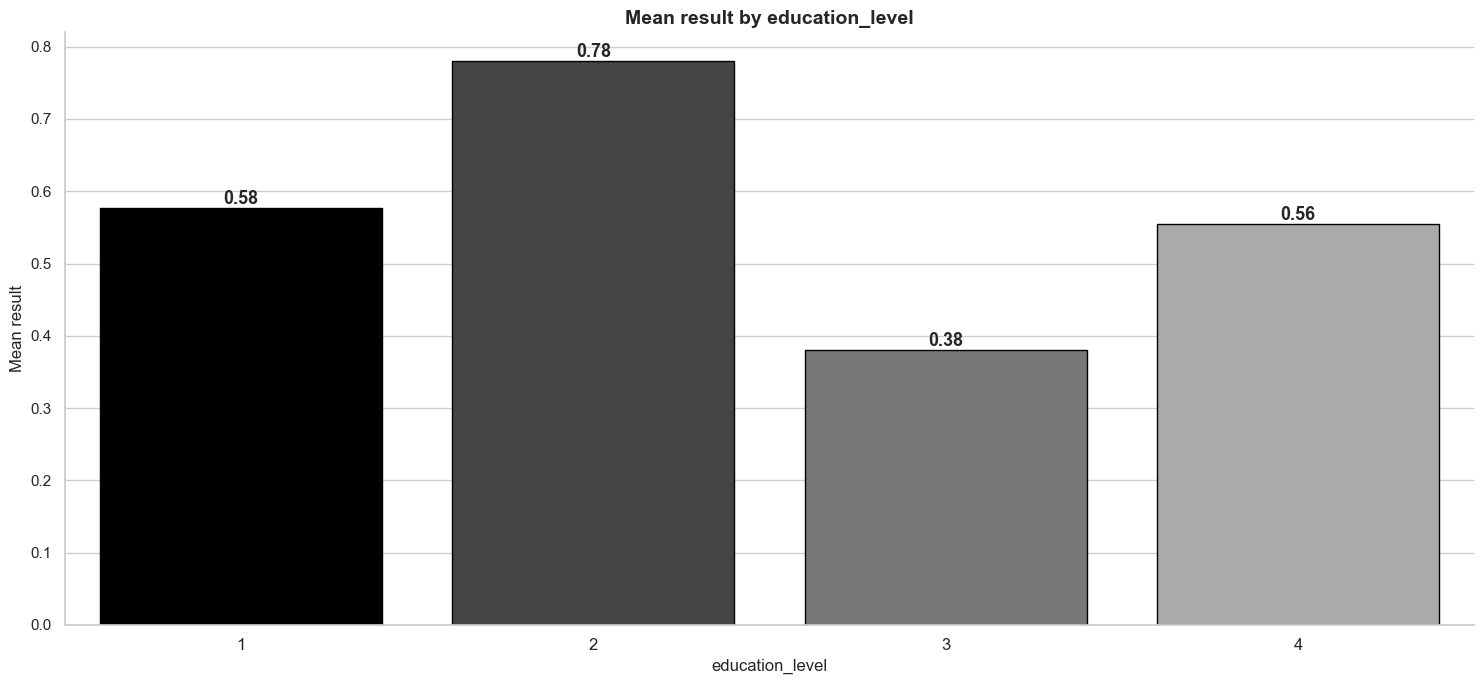

C:\Users\KW\AppData\Local\Temp\ipykernel_8384\1369376441.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
C:\Users\KW\AppData\Local\Temp\ipykernel_8384\1369376441.py:10: UserWarning: 
The palette list has fewer values (5) than needed (7) and will cycle, which may produce an uninterpretable plot.
  ax = sns.barplot(


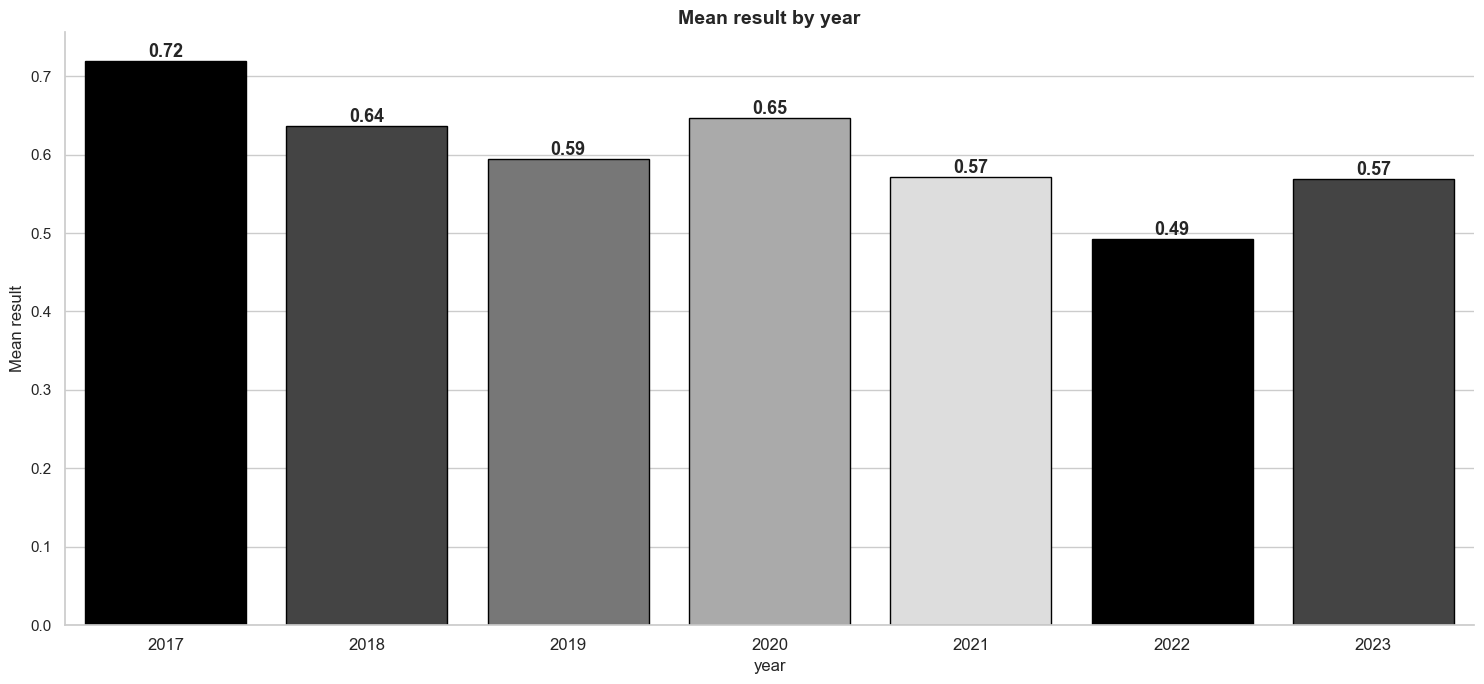

C:\Users\KW\AppData\Local\Temp\ipykernel_8384\1369376441.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
C:\Users\KW\AppData\Local\Temp\ipykernel_8384\1369376441.py:10: UserWarning: 
The palette list has fewer values (5) than needed (11) and will cycle, which may produce an uninterpretable plot.
  ax = sns.barplot(


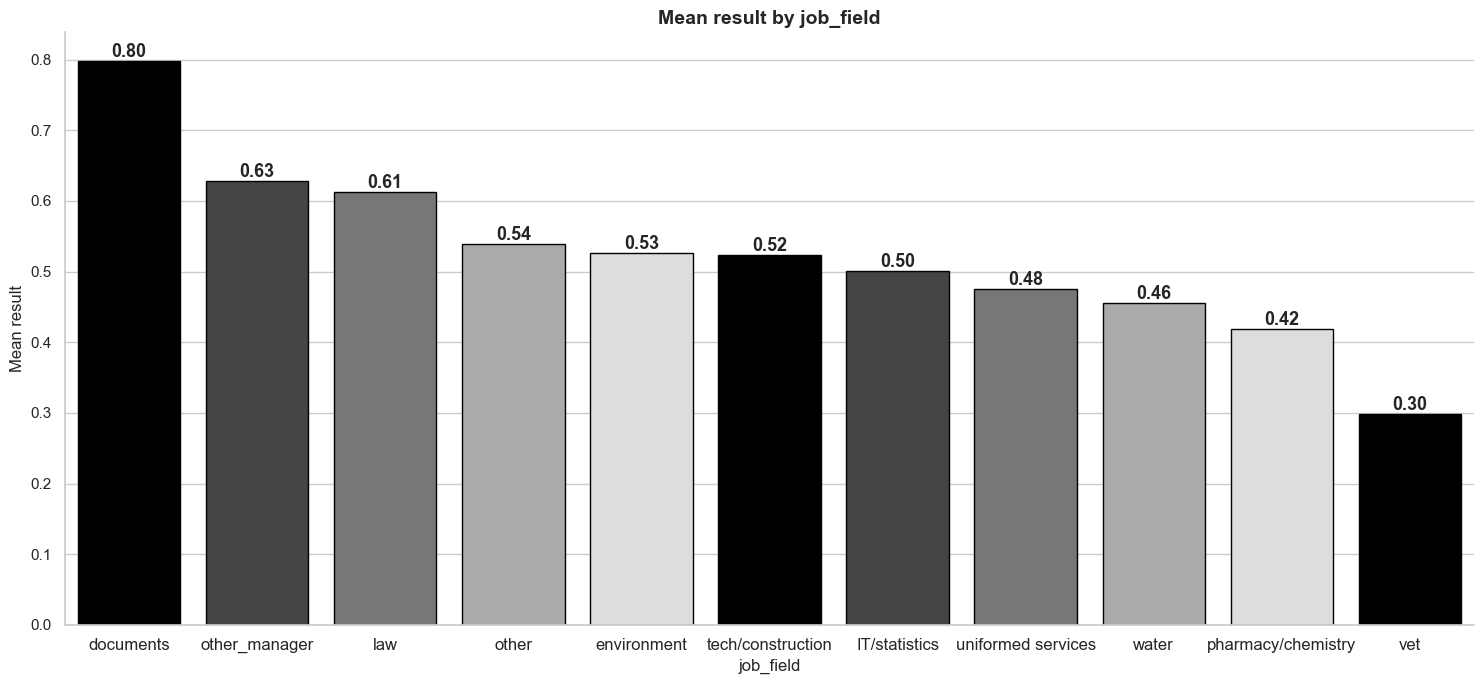

C:\Users\KW\AppData\Local\Temp\ipykernel_8384\1369376441.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
C:\Users\KW\AppData\Local\Temp\ipykernel_8384\1369376441.py:10: UserWarning: 
The palette list has fewer values (5) than needed (6) and will cycle, which may produce an uninterpretable plot.
  ax = sns.barplot(


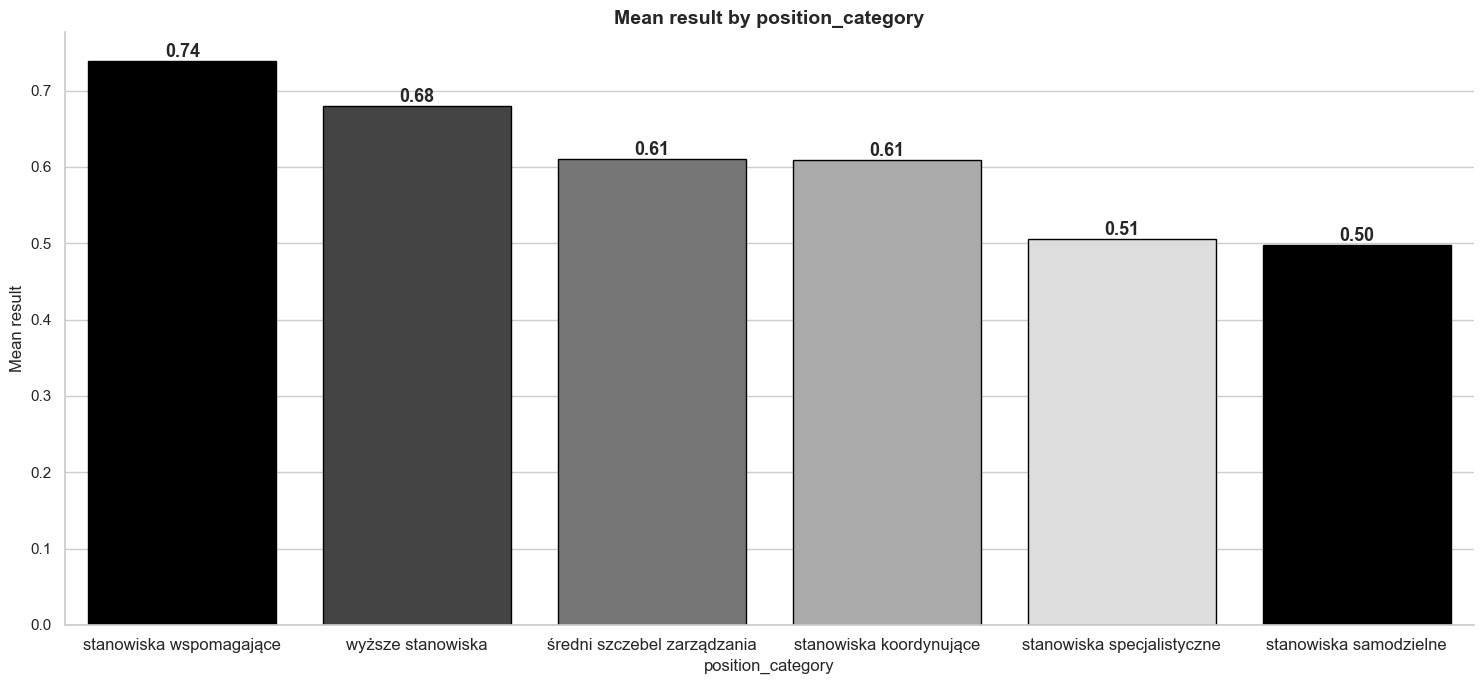

In [50]:
plot_bar_columns = [
    'education_level',
    'year',
    'job_field',
    'position_category'
]

for column in plot_bar_columns:
    plot_ibcs_bar_chart(df, column)

##### Time series

In [ ]:
# Dealing with categorical columns.
df = pd.get_dummies(df, columns=['position_category', 'job_field'], drop_first=True)

In [27]:
# Aggregating data to institution-level.
df_institution_level = df.groupby(['district', 'voivodeship', 'institution']).agg('mean').reset_index()
df_institution_year_level = df.groupby(['district', 'voivodeship', 'institution', 'year']).agg('mean').reset_index()

In [28]:
# Variable correlation
numerical_columns_df = df_institution_level[[
    'work_time',
    'ad_views',
    'applicants',
    'offer_salary_mentioned',
    'salary_for_position',
    'women_percentage',
    'bdl_feminization_coefficient',
    'fluctuation',
    'employment_contract',
    'bdl_avg_house_pricing',
    'bdl_age_median',
    'bdl_migration_coefficient',
    'bdl_district_expenses',
    'bdl_average_salary',
    'offer_salary_mentioned',
    'vacancies',
    'len_requirements',
    'len_nice_to_have',
    'len_responsibilities',
    'result'
]]


correlation = numerical_columns_df.corr()['result']

# Display the correlation matrix
print(correlation)

work_time                            NaN
ad_views                        0.359469
applicants                      0.429073
offer_salary_mentioned          0.183391
salary_for_position            -0.177378
women_percentage                0.004091
bdl_feminization_coefficient   -0.050257
fluctuation                     0.031808
employment_contract             0.138530
bdl_avg_house_pricing          -0.157657
bdl_age_median                 -0.013383
bdl_migration_coefficient      -0.115317
bdl_district_expenses          -0.034299
bdl_average_salary             -0.190822
offer_salary_mentioned          0.183391
vacancies                       0.041879
len_requirements               -0.027215
len_nice_to_have                0.031908
len_responsibilities           -0.053243
result                          1.000000
Name: result, dtype: float64


In [29]:
df_institution_level.describe()

district  voivodeship       result  education_level  work_time  \
count  3144.000000  3144.000000  3144.000000      3144.000000     3144.0   
mean     34.274809    17.166031     0.741668         2.314288        1.0   
std      26.676296     9.254237     0.280071         0.743862        0.0   
min       1.000000     2.000000     0.000000         1.000000        1.0   
25%       9.000000    10.000000     0.531113         2.000000        1.0   
50%      21.000000    16.000000     0.831301         2.166667        1.0   
75%      62.000000    24.000000     1.000000         2.920000        1.0   
max      79.000000    32.000000     1.000000         4.000000        1.0   

         vacancies      ad_views         year  advertised_institution  \
count  3144.000000   3144.000000  3144.000000             2387.000000   
mean      1.080875   2136.125259  2020.405443                0.725015   
std       0.232582    643.795895     1.165095                0.416642   
min       1.000000    262.000000  2017.000000                0.000000   
25%       1.000000   1712.500000  2019.687500                0.344749   
50%       1.000000   2110.750000  2020.400000                1.000000   
75%       1.052632   2502.430195  2021.000000                1.000000   
max       4.333333  11287.000000  2023.000000                1.000000   

        applicants  ...  job_field_documents  job_field_environment  \
count  2644.000000  ...          3144.000000            3144.000000   
mean      8.853254  ...             0.197945               0.025557   
std       8.569620  ...             0.331450               0.126487   
min       0.000000  ...             0.000000               0.000000   
25%       3.000000  ...             0.000000               0.000000   
50%       6.000000  ...             0.000000               0.000000   
75%      12.364982  ...             0.285714               0.000000   
max      69.000000  ...             1.000000               1.000000   

       job_field_law  job_field_other  job_field_other_manager  \
count    3144.000000      3144.000000              3144.000000   
mean        0.450982         0.051012                 0.019892   
std         0.406888         0.187669                 0.091656   
min         0.000000         0.000000                 0.000000   
25%         0.000000         0.000000                 0.000000   
50%         0.334524         0.000000                 0.000000   
75%         0.941176         0.000000                 0.000000   
max         1.000000         1.000000                 1.000000   

       job_field_pharmacy/chemistry  job_field_tech/construction  \
count                   3144.000000                  3144.000000   
mean                       0.013611                     0.034097   
std                        0.106860                     0.147301   
min                        0.000000                     0.000000   
25%                        0.000000                     0.000000   
50%                        0.000000                     0.000000   
75%                        0.000000                     0.000000   
max                        1.000000                     1.000000   

       job_field_uniformed services  job_field_vet  job_field_water  
count                   3144.000000    3144.000000      3144.000000  
mean                       0.063265       0.101175         0.004582  
std                        0.202856       0.287140         0.060768  
min                        0.000000       0.000000         0.000000  
25%                        0.000000       0.000000         0.000000  
50%                        0.000000       0.000000         0.000000  
75%                        0.000000       0.000000         0.000000  
max                        1.000000       1.000000         1.000000  

[8 rows x 39 columns]

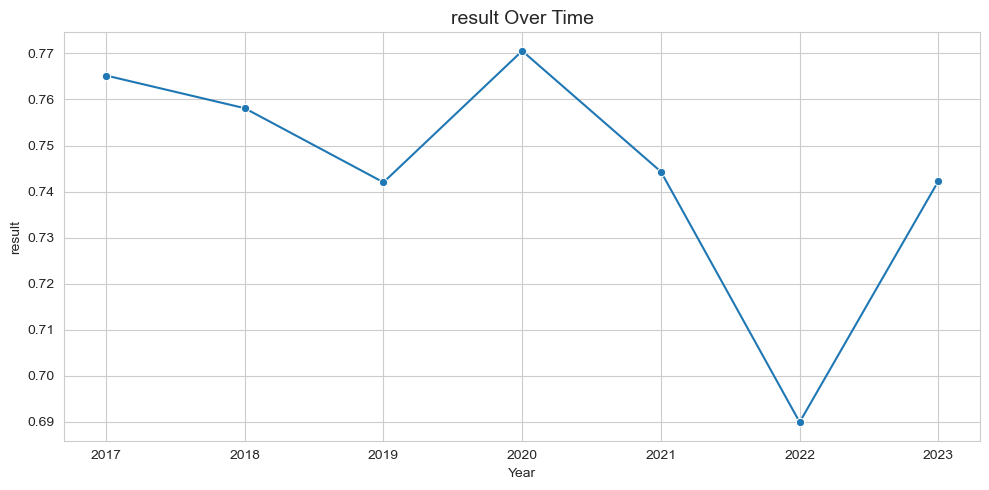

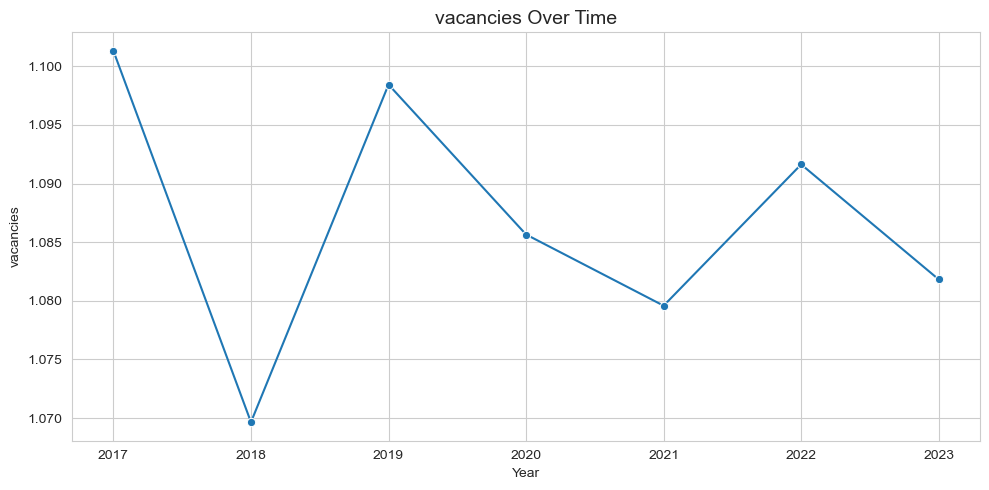

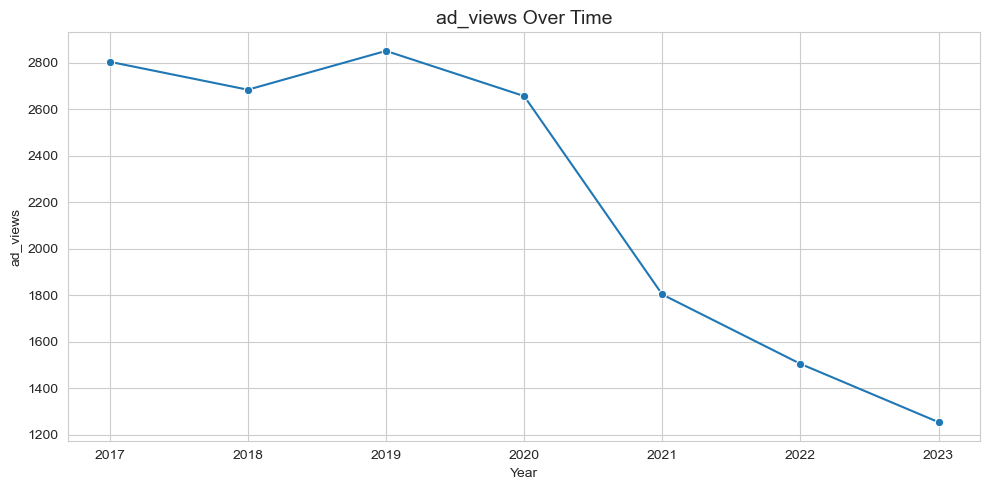

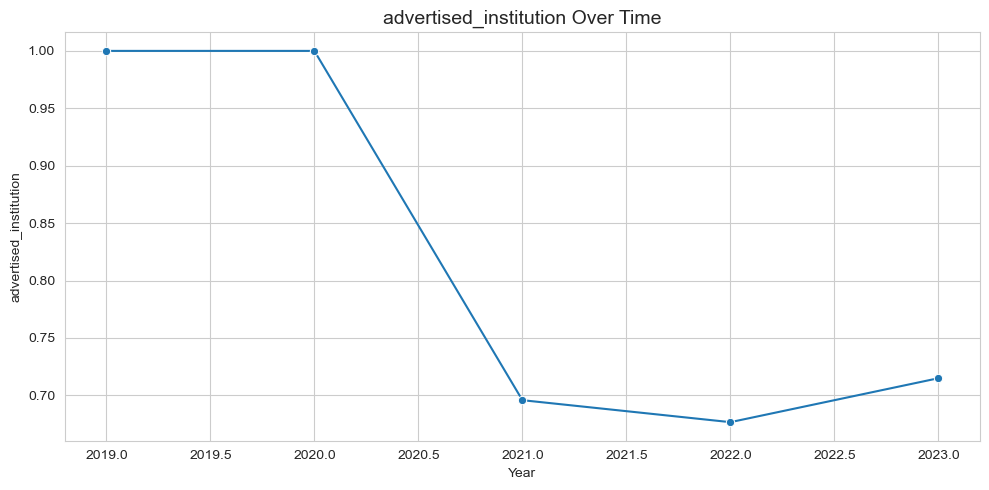

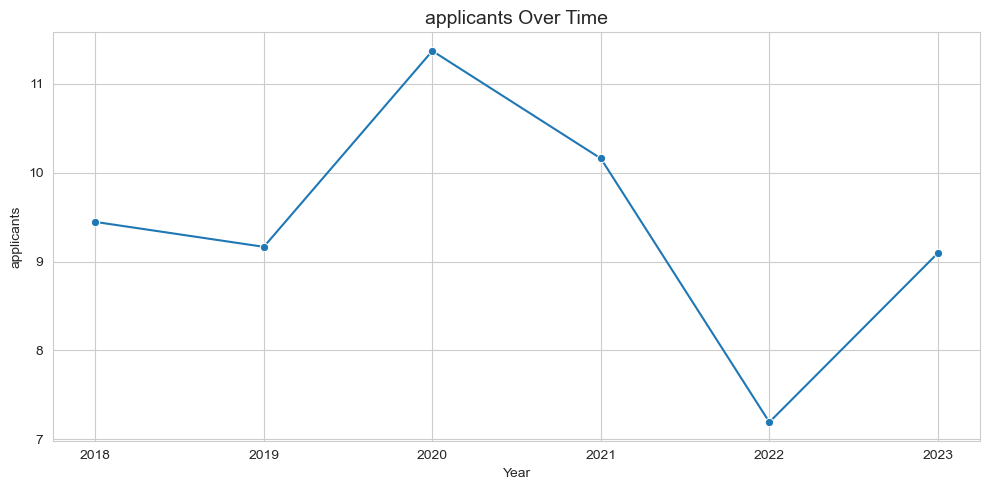

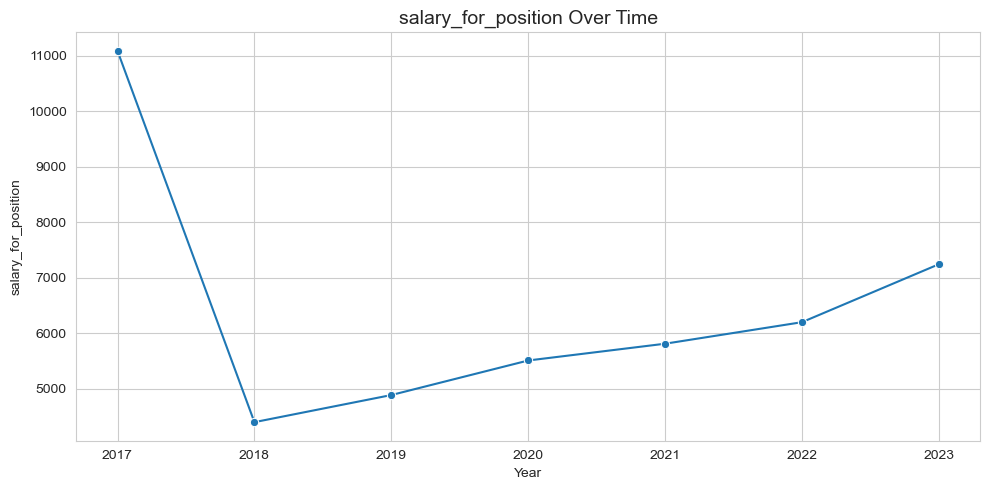

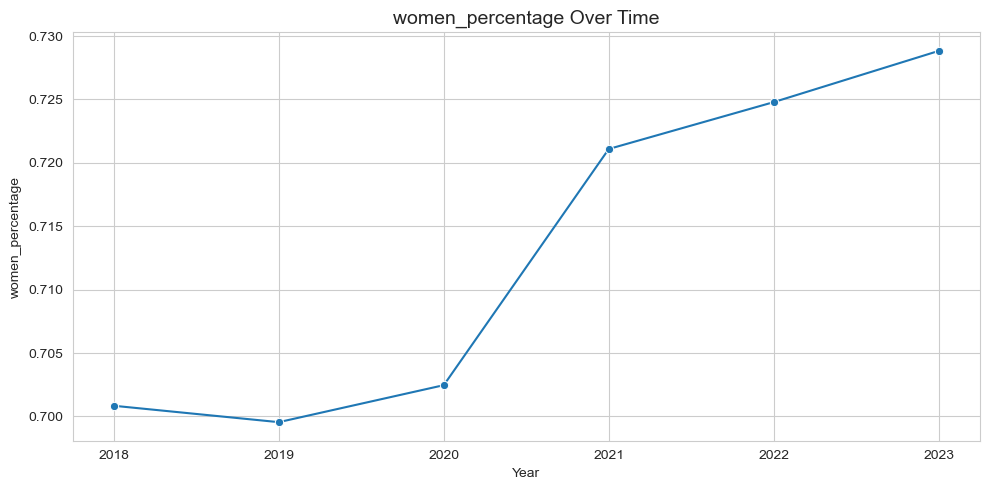

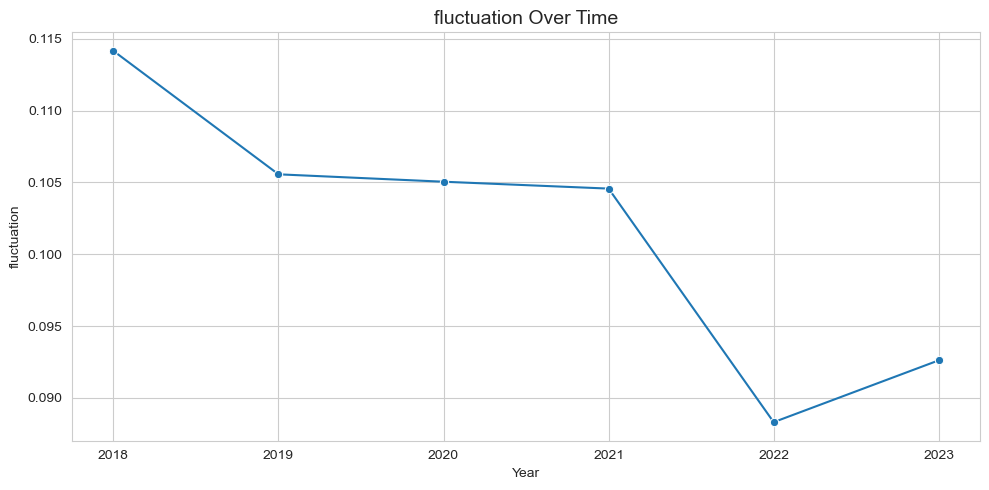

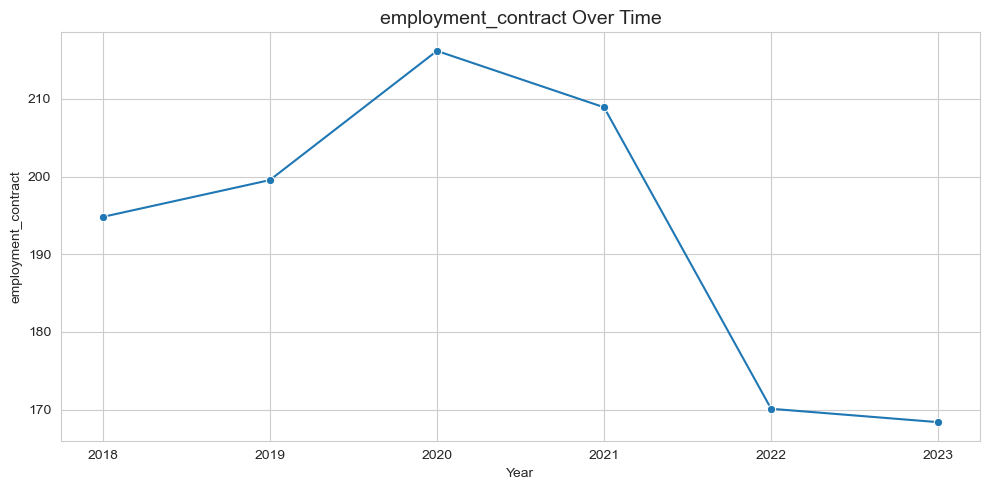

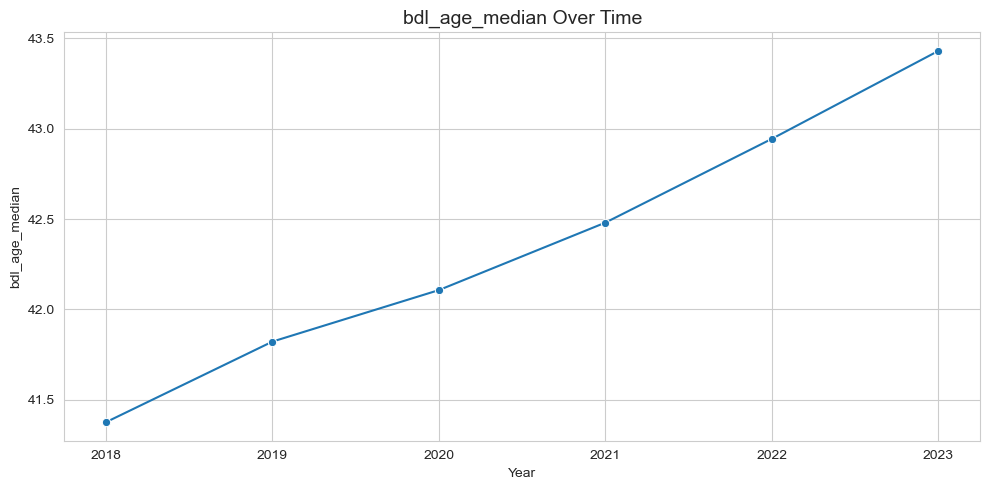

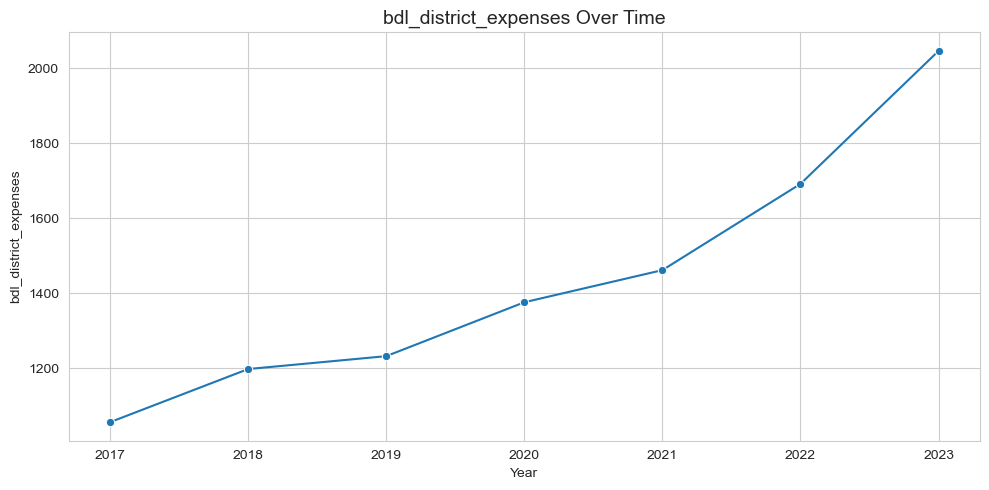

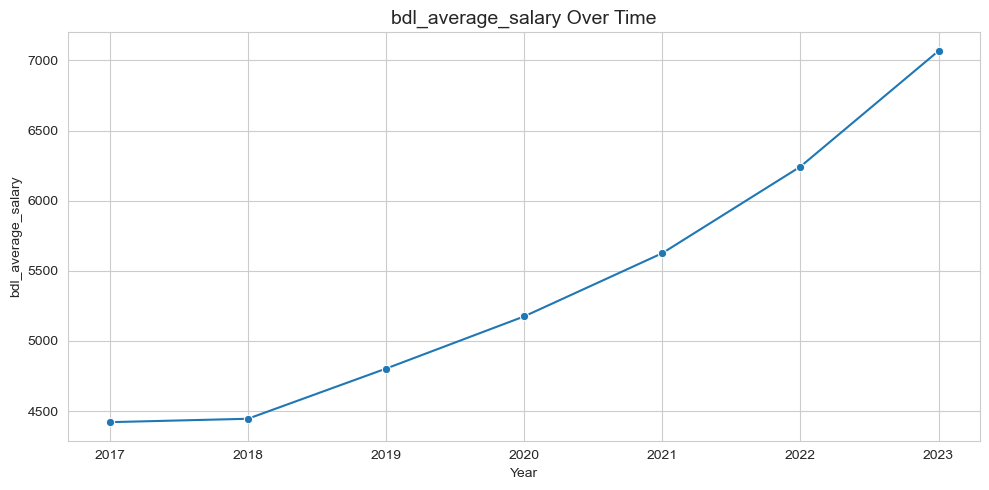

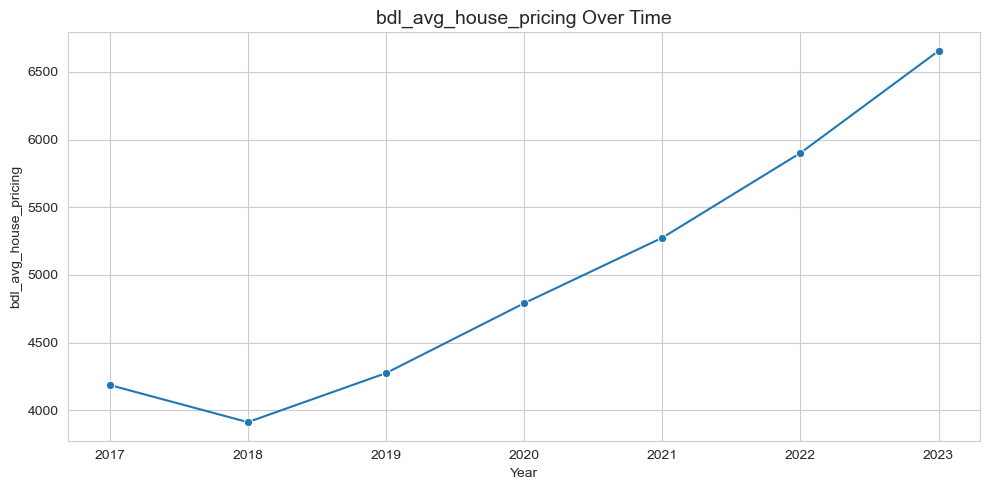

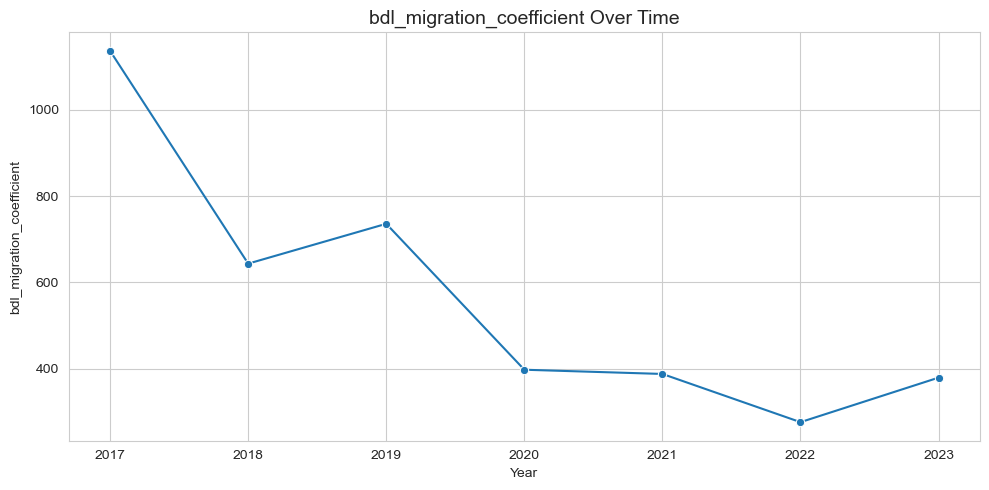

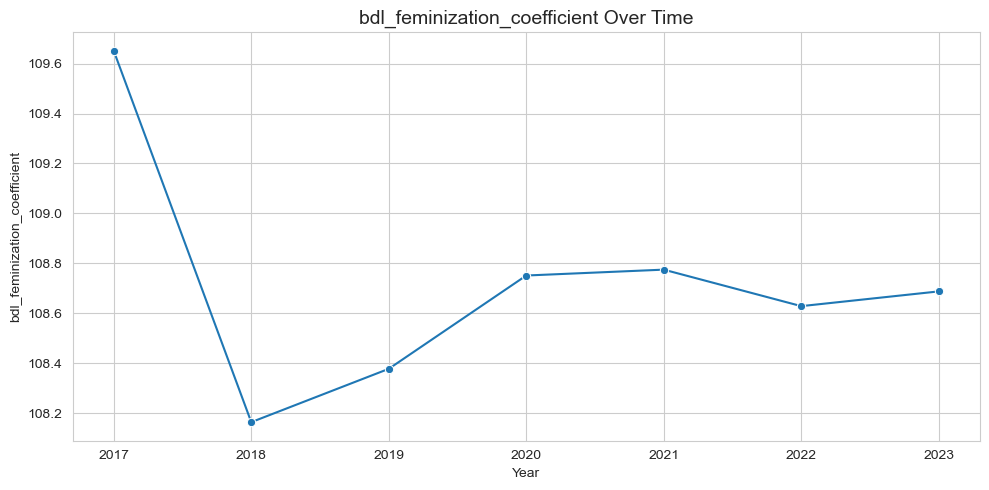

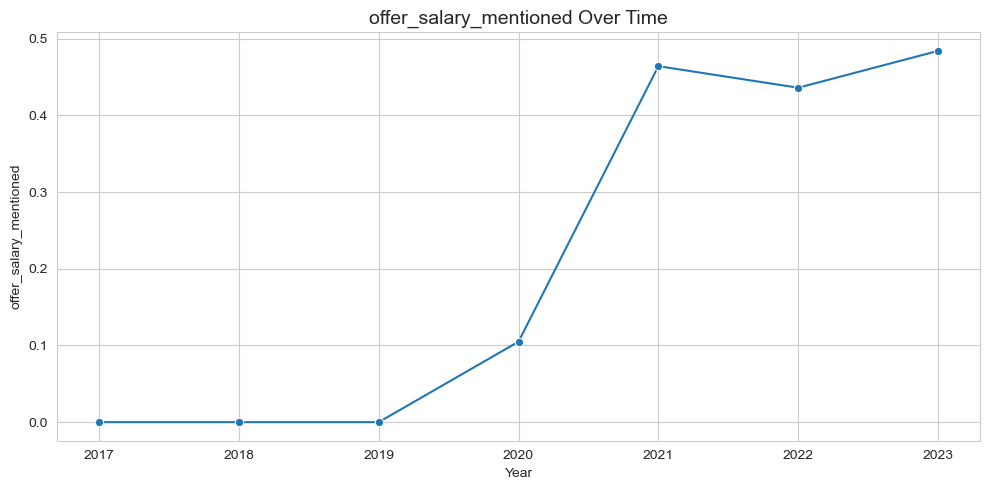

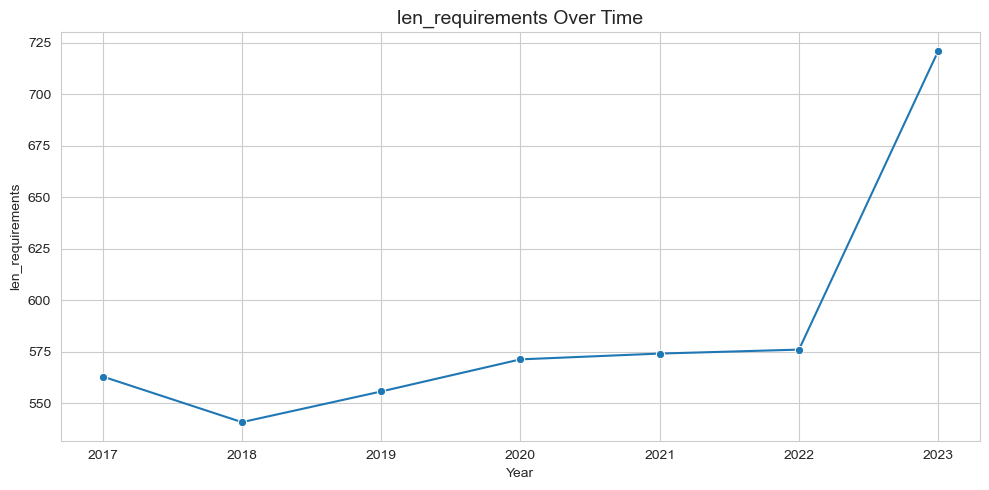

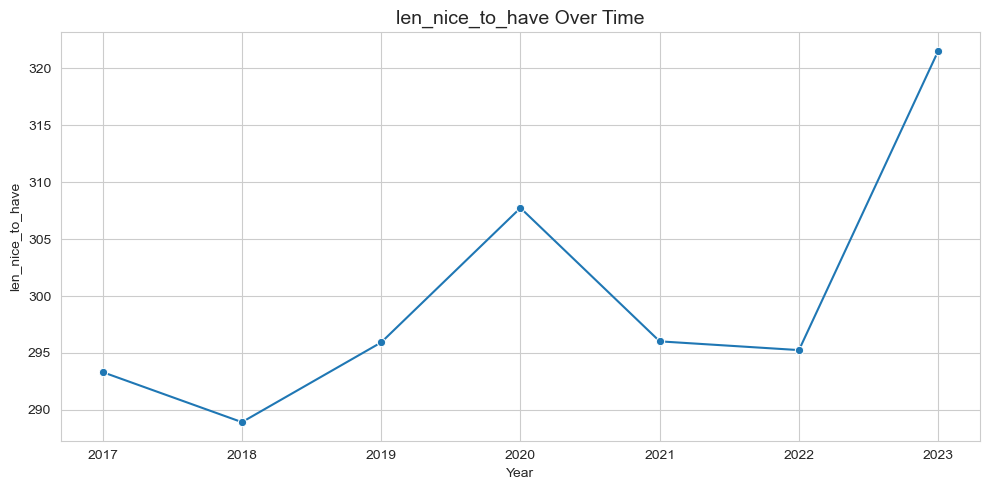

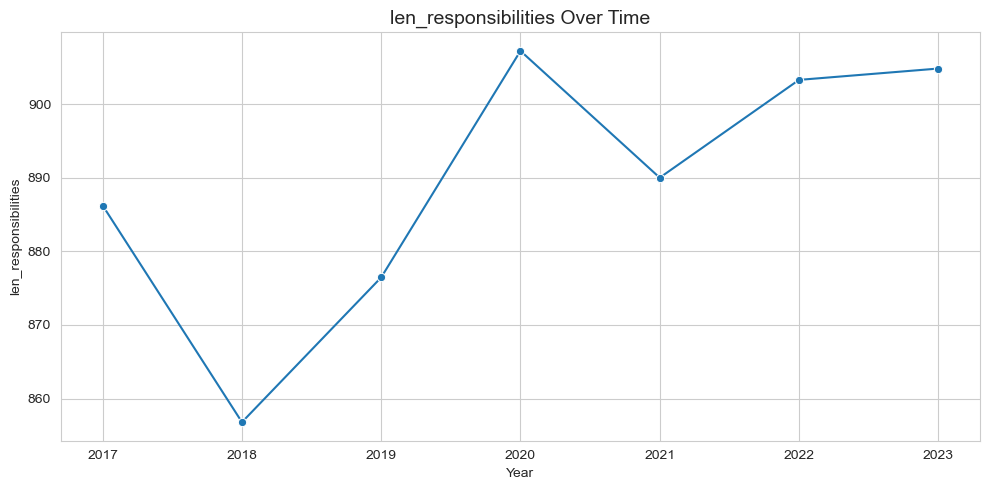

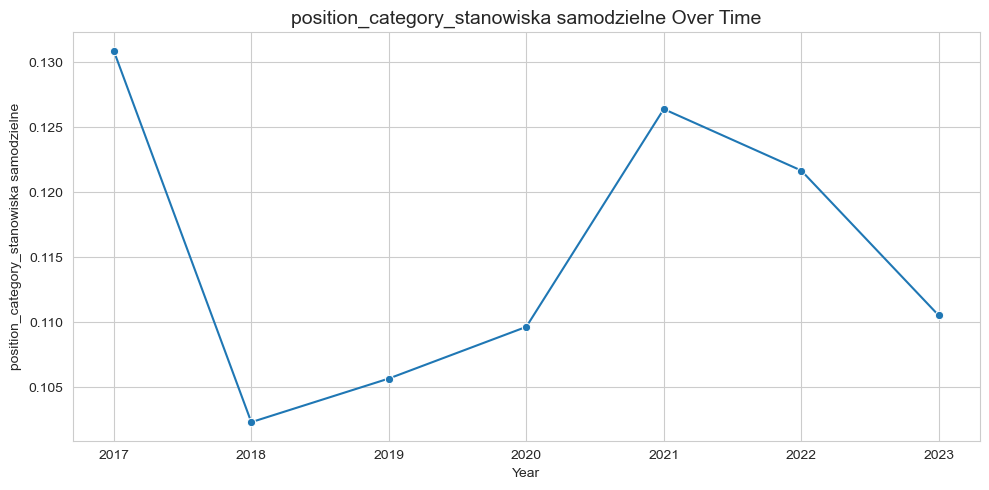

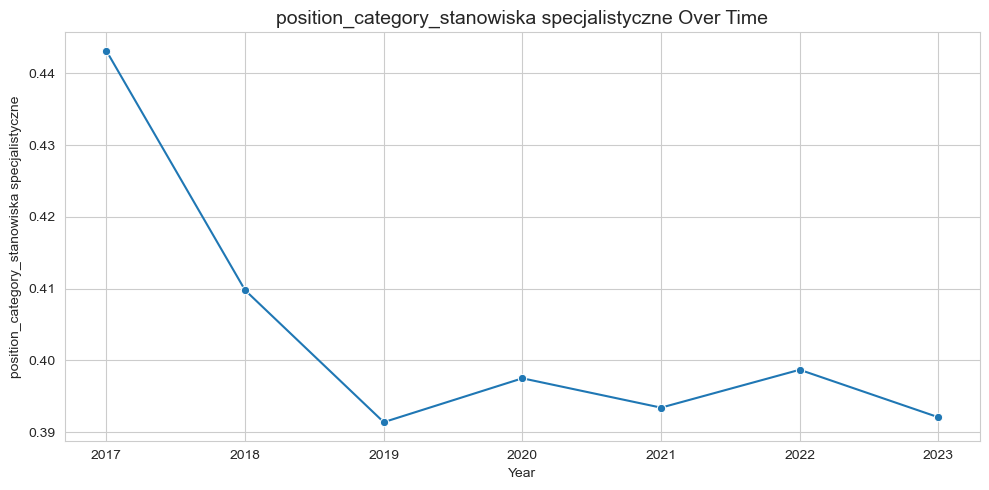

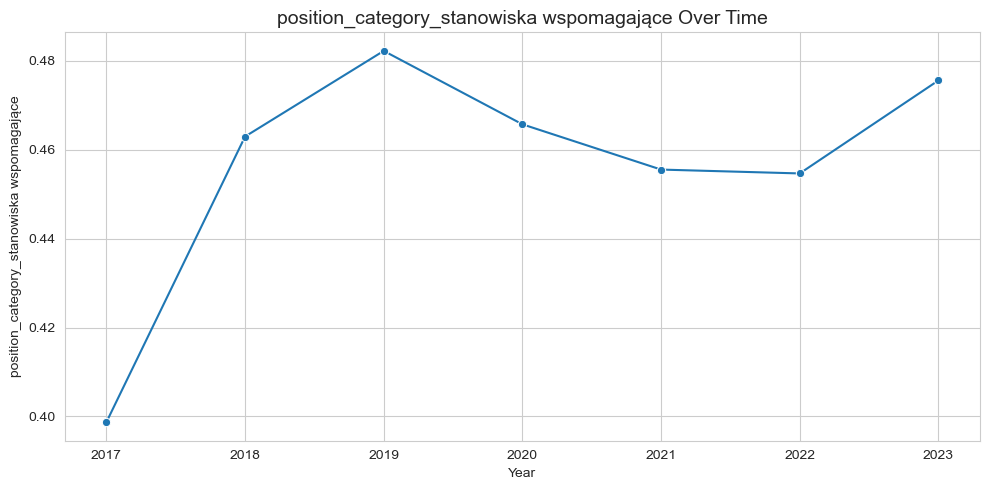

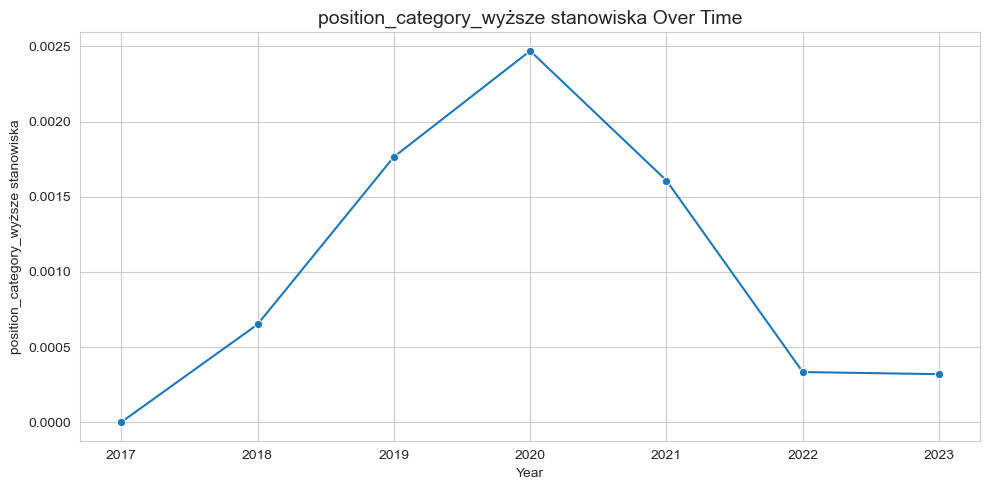

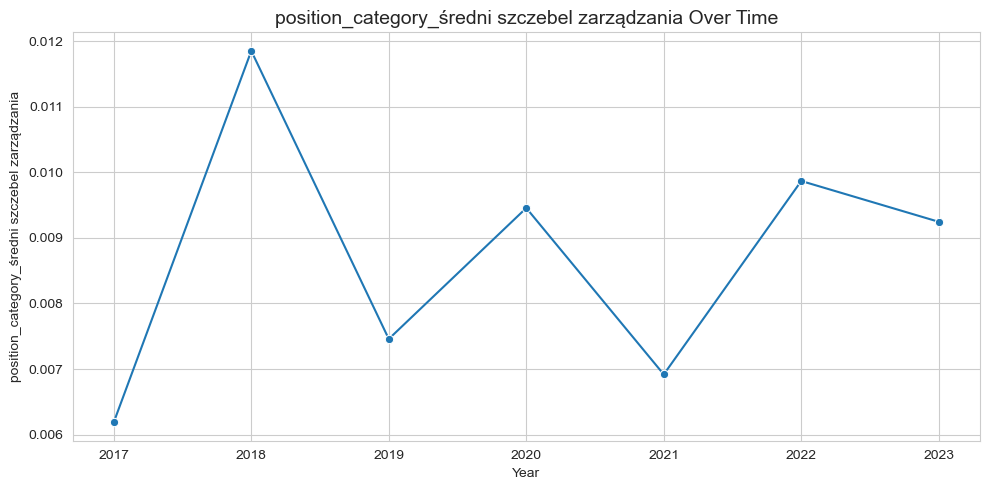

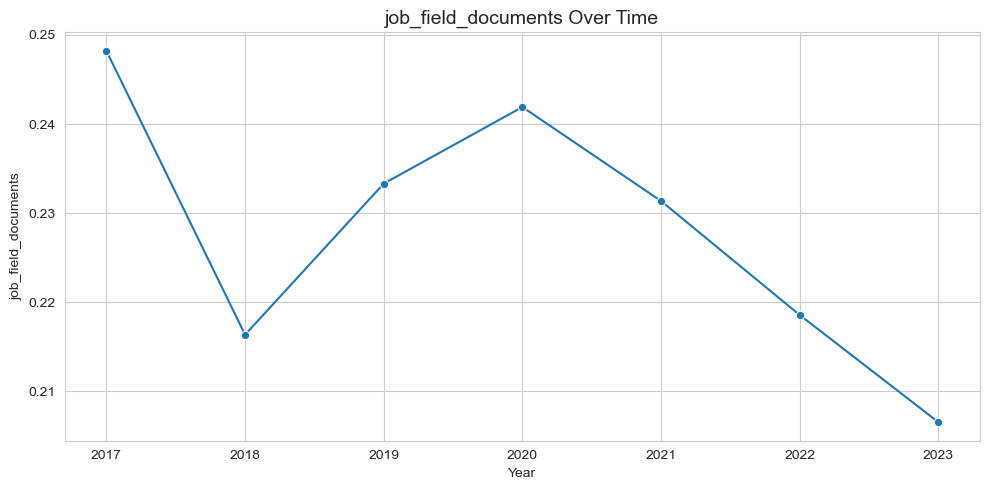

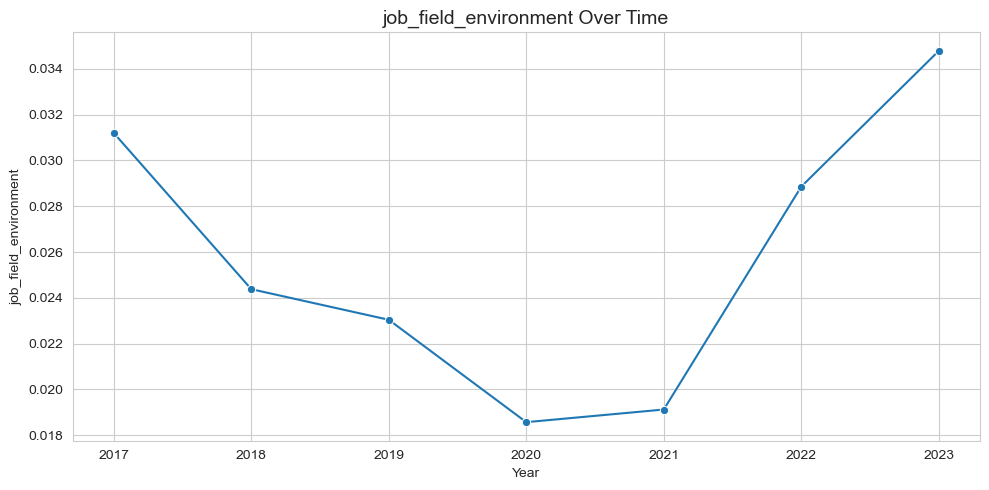

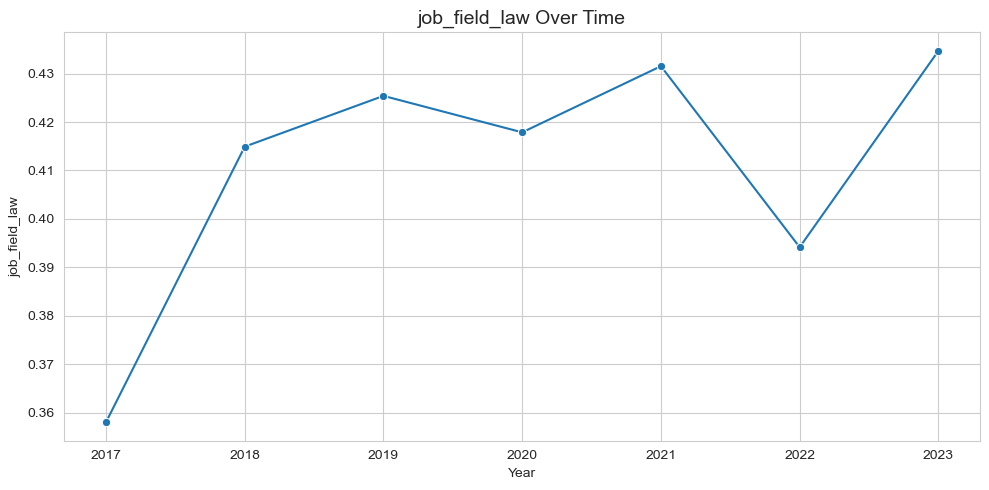

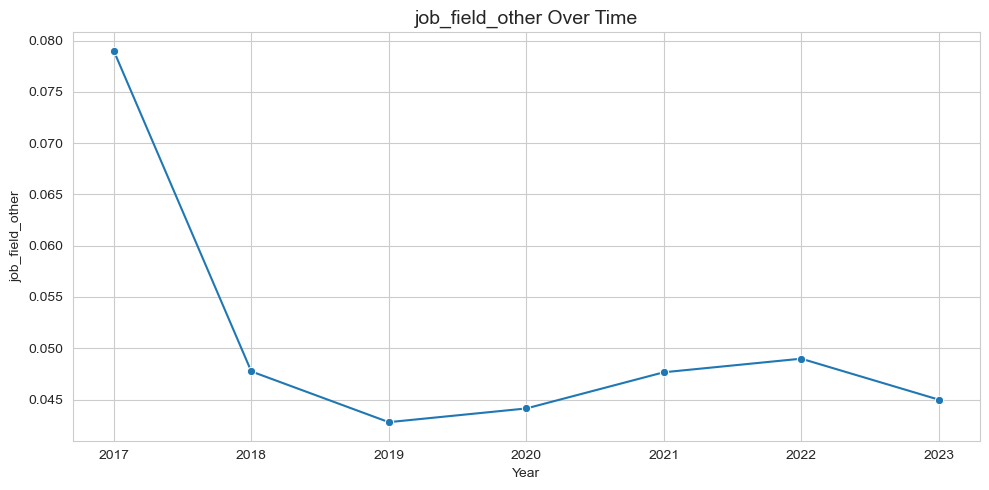

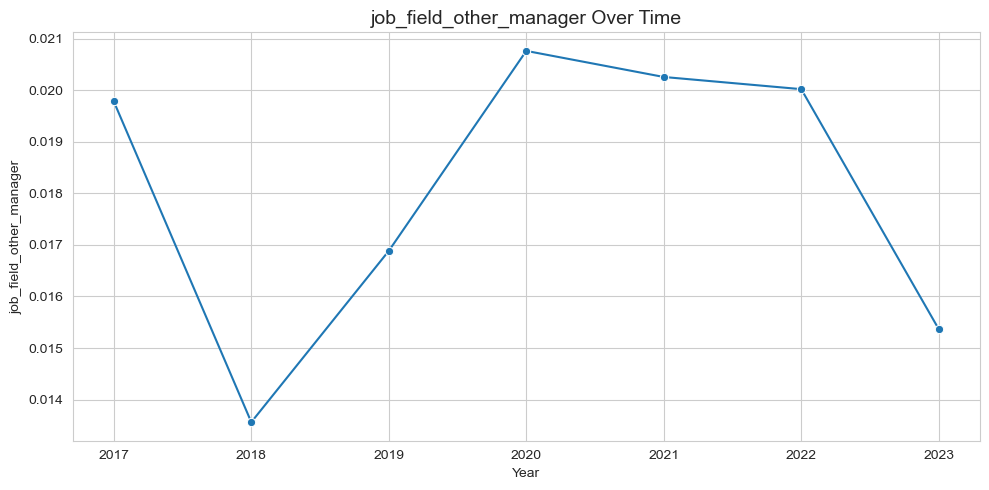

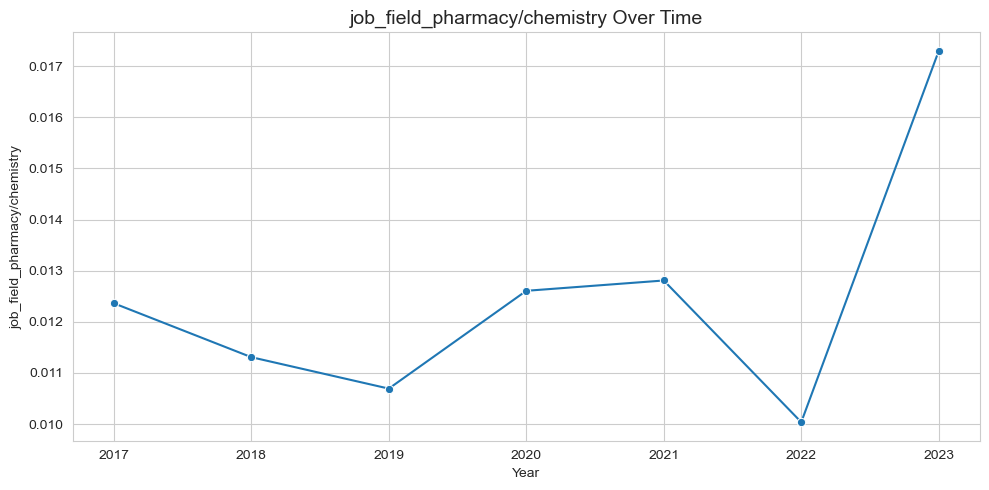

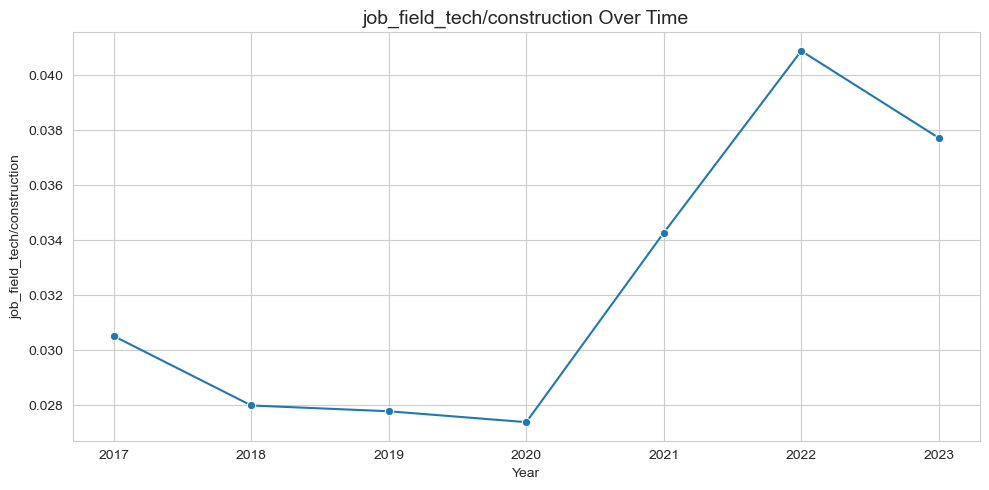

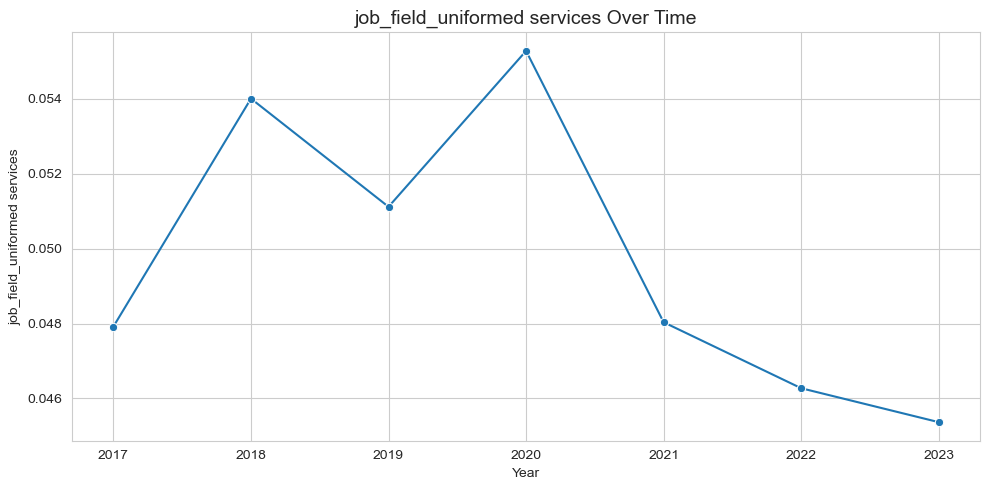

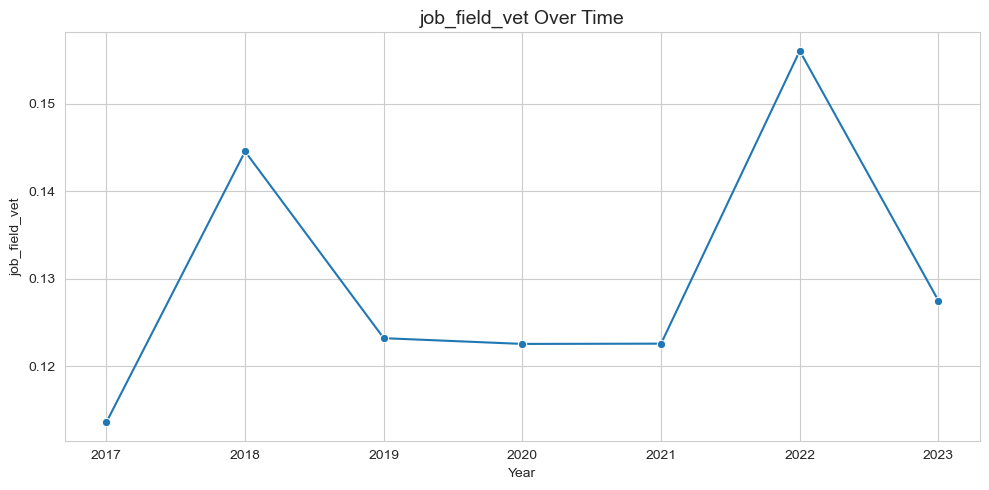

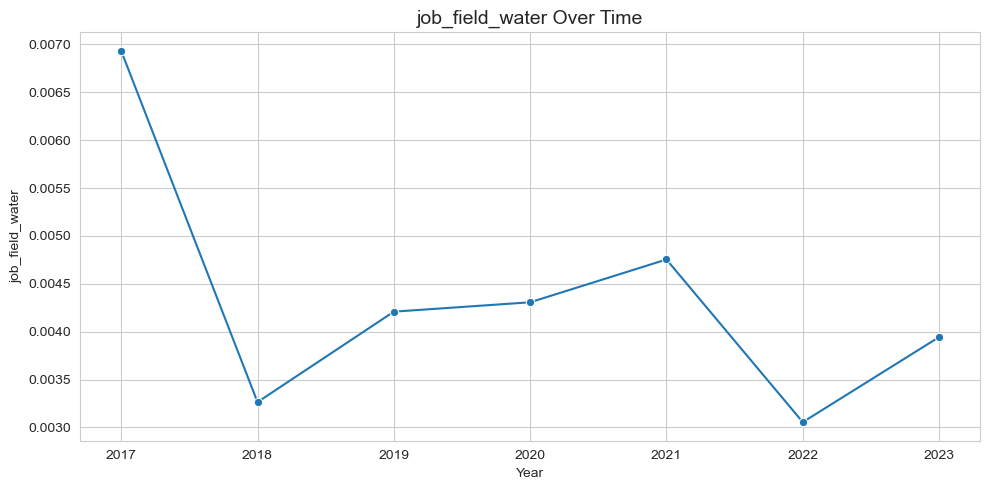

In [30]:
def plot_individual_time_series(dataframe):
    # Columns to exclude from plotting
    exclude_columns = ['voivodeship', 'district', 'education_level', 'work_time', 'institution']

    # Group by year and compute mean for numeric columns only.
    df_grouped = dataframe.groupby('year').mean(numeric_only=True)

    # Drop the excluded columns (if they exist).
    columns_to_plot = [col for col in df_grouped.columns if col not in exclude_columns]

    # Plot each column individually
    for column in columns_to_plot:
        plt.figure(figsize=(10, 5))
        sns.lineplot(x=df_grouped.index, y=df_grouped[column], marker='o')
        plt.title(f"{column} over Time", fontsize=14)
        plt.xlabel("Year")
        plt.ylabel(column)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

plot_individual_time_series(df_institution_year_level)

##### Variability charts

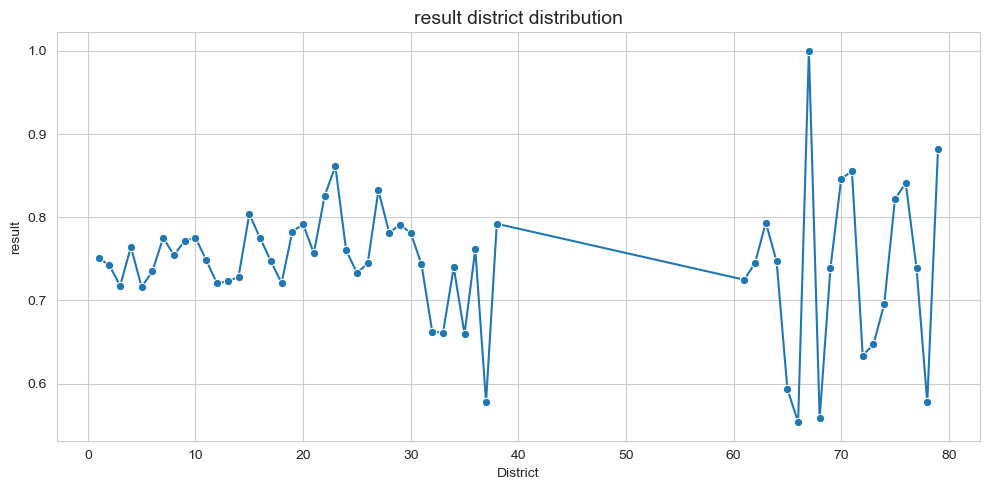

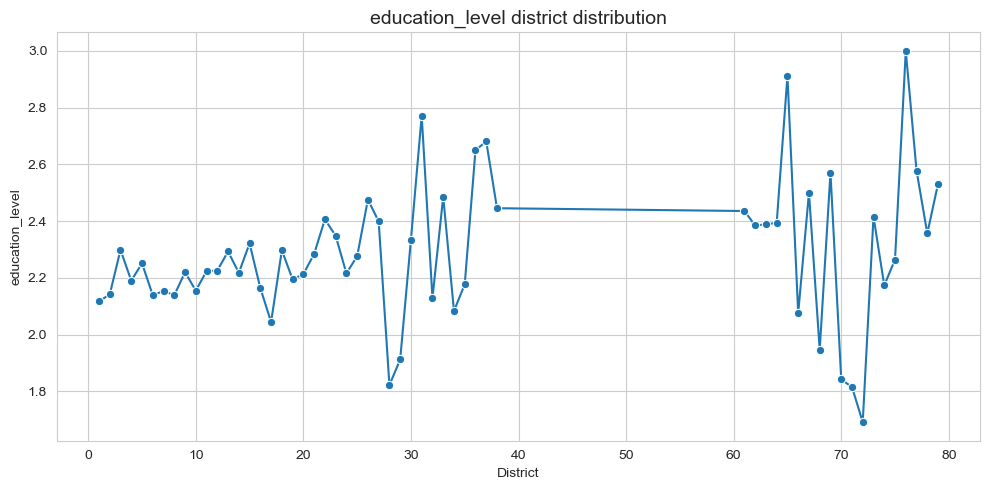

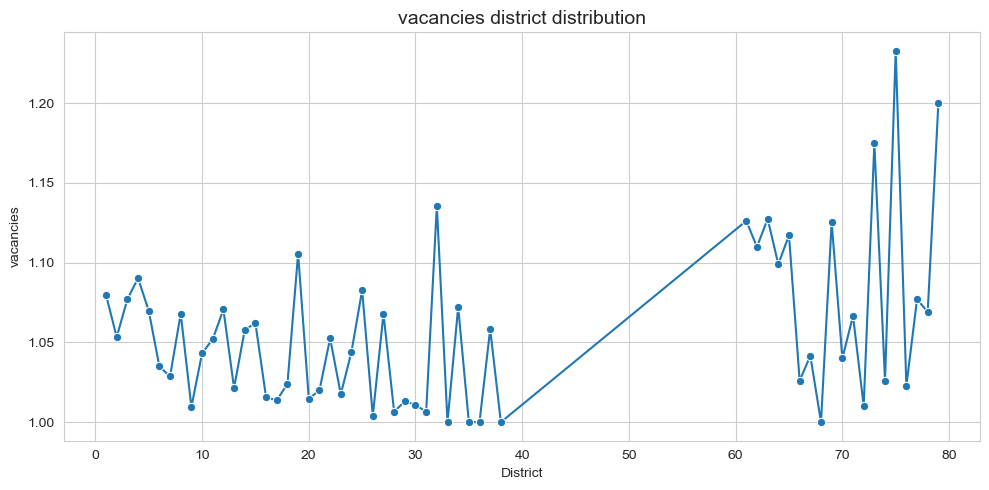

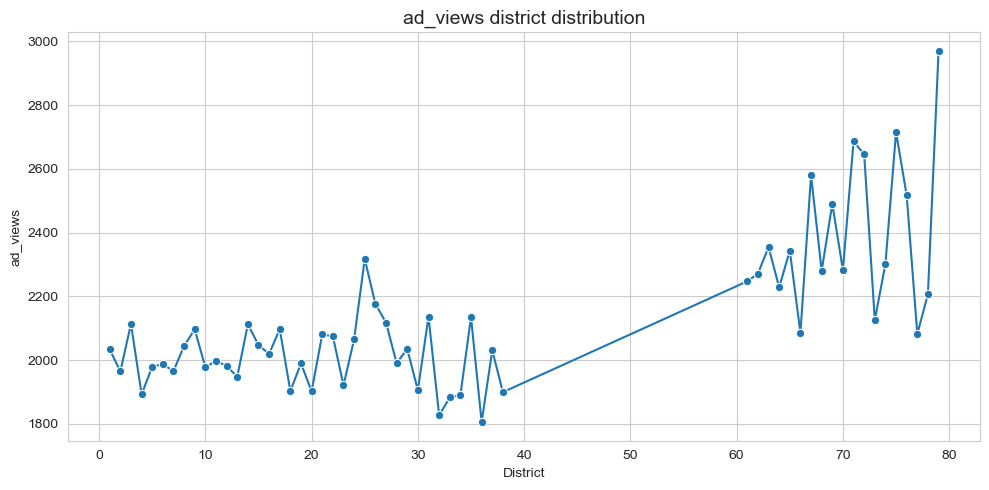

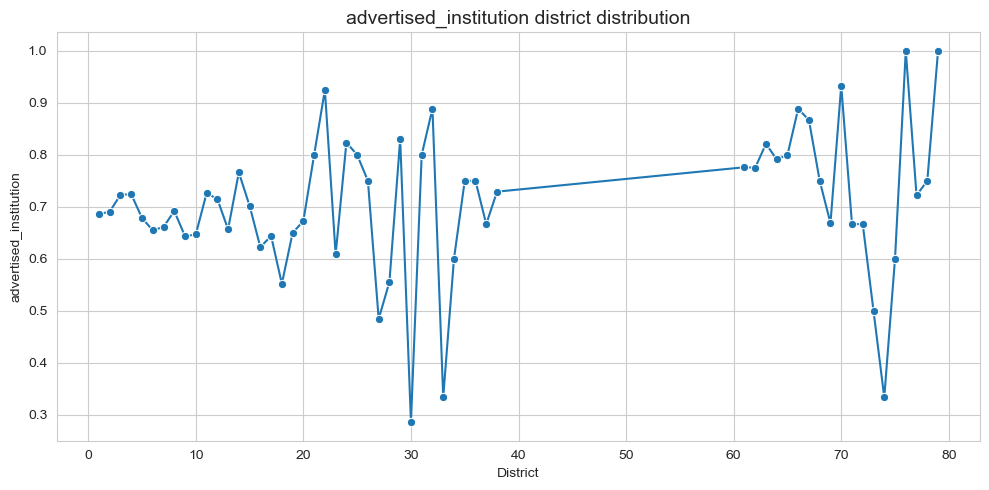

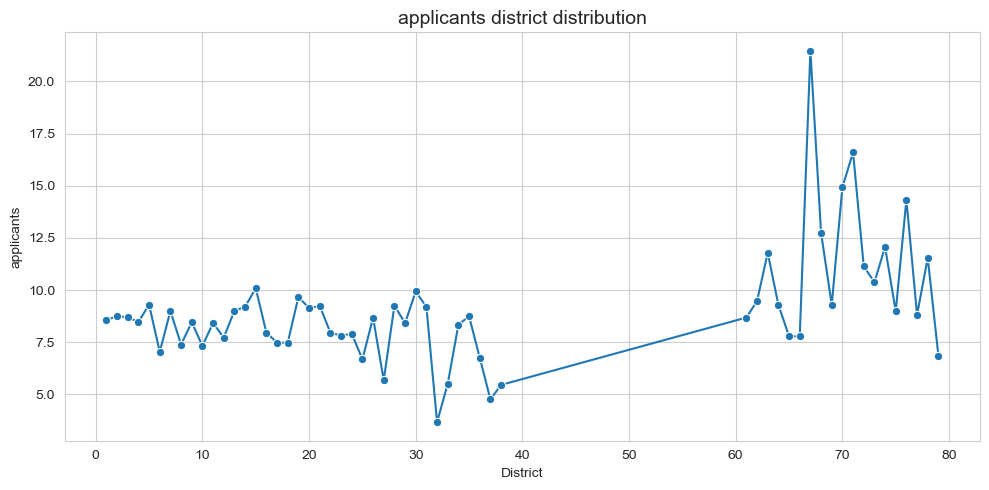

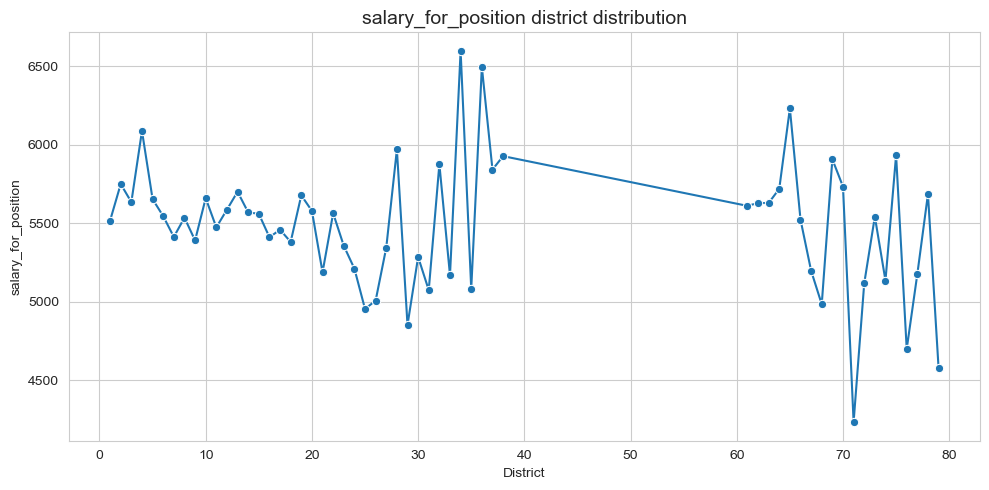

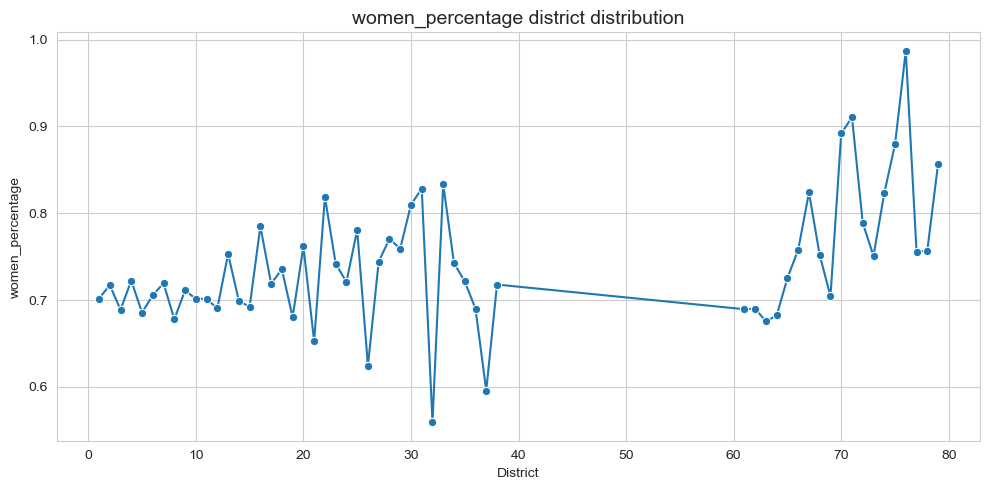

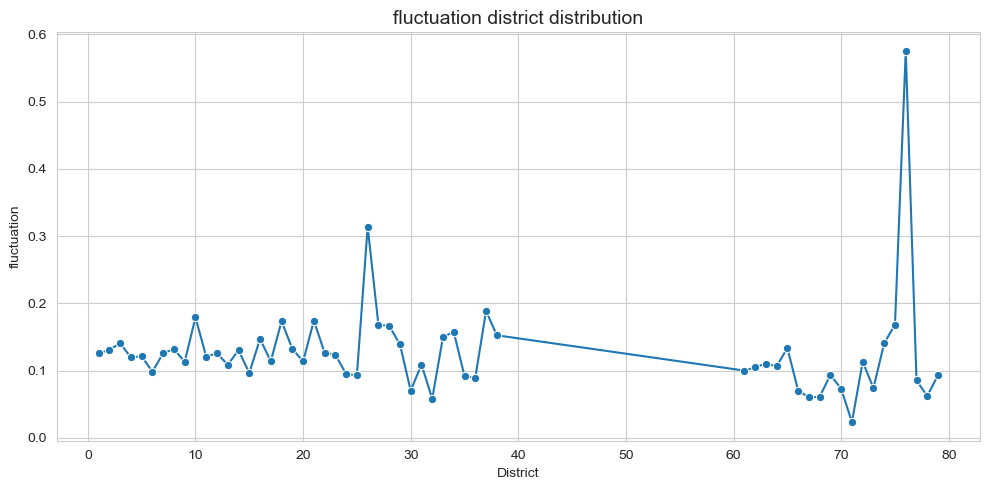

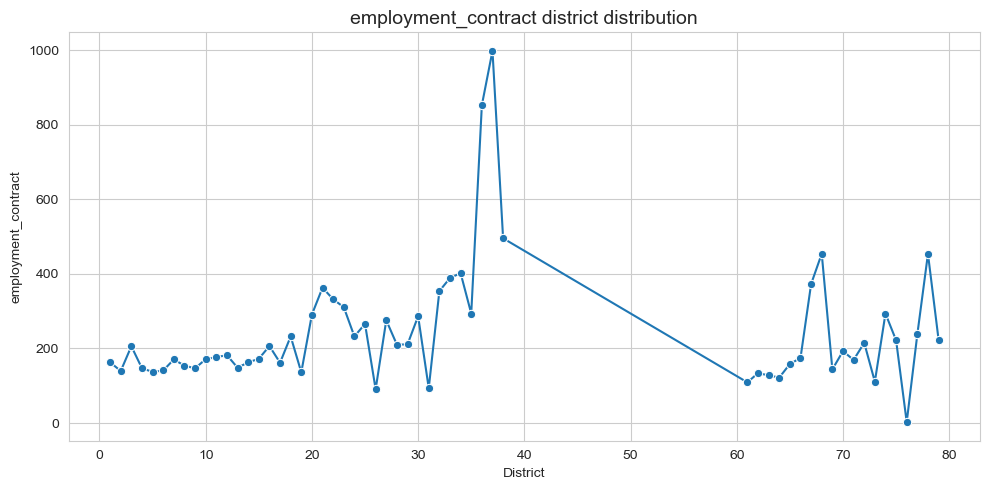

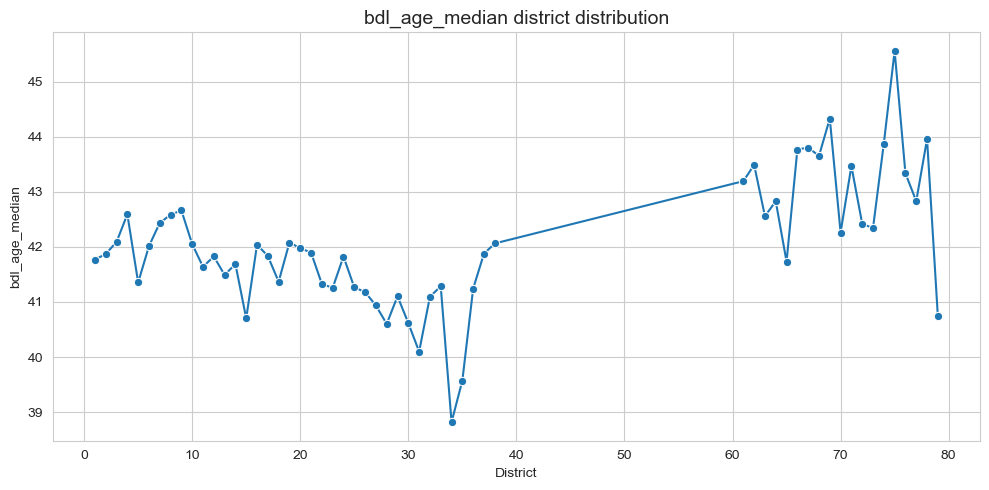

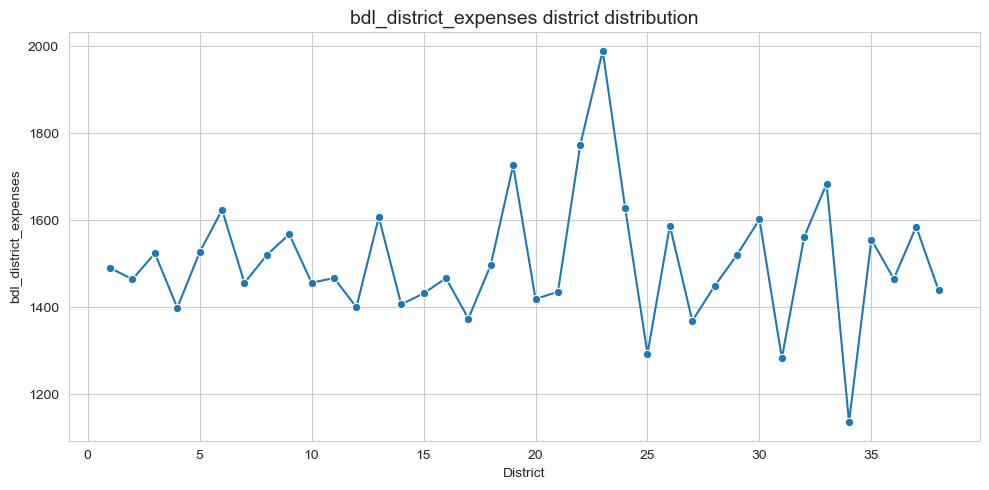

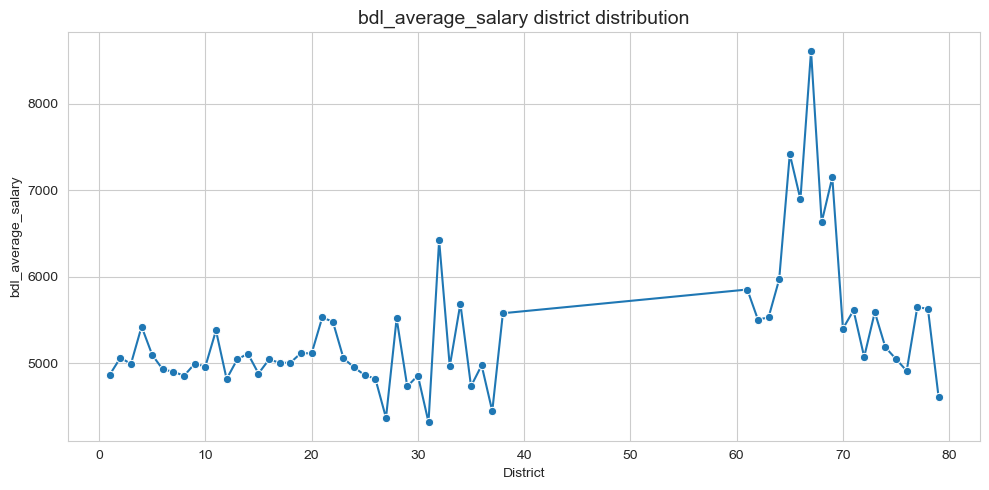

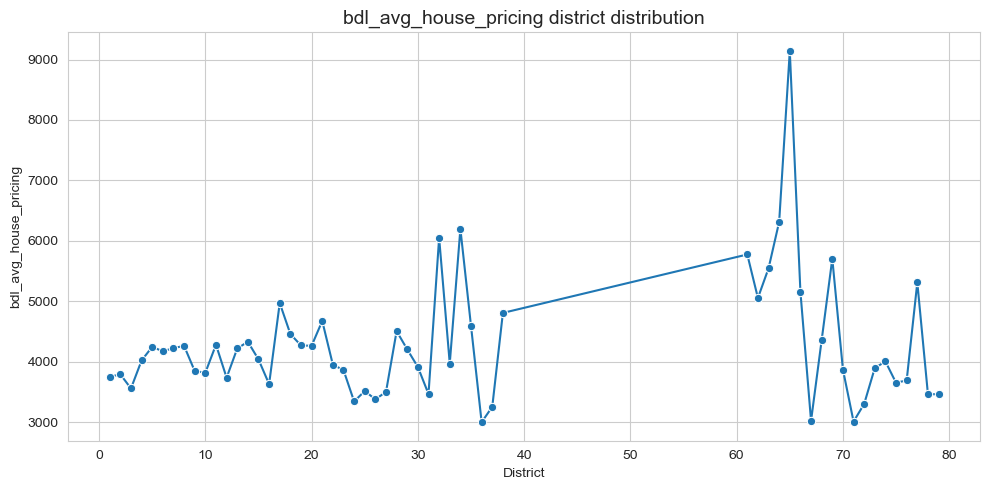

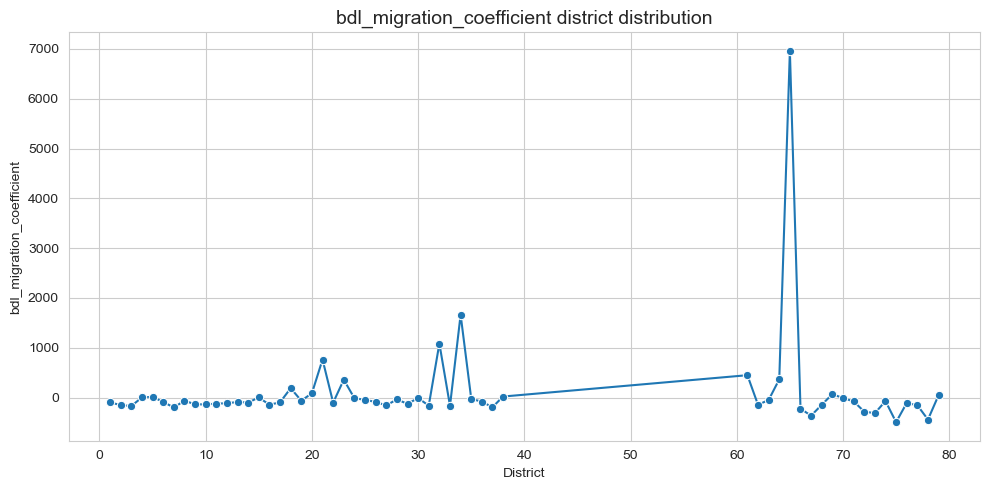

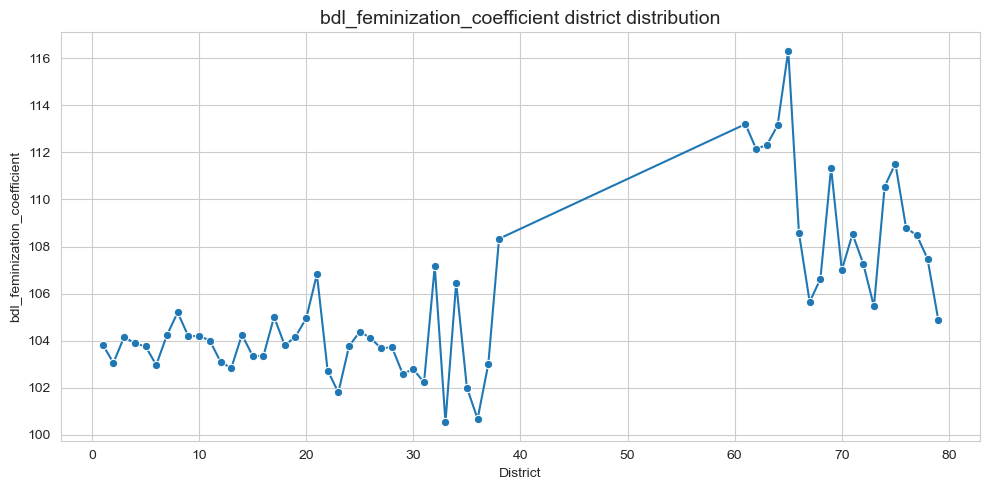

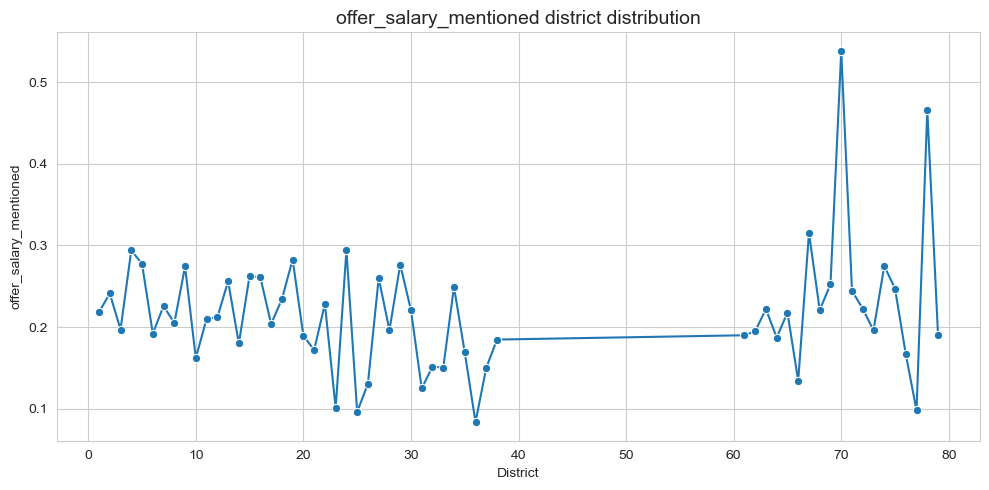

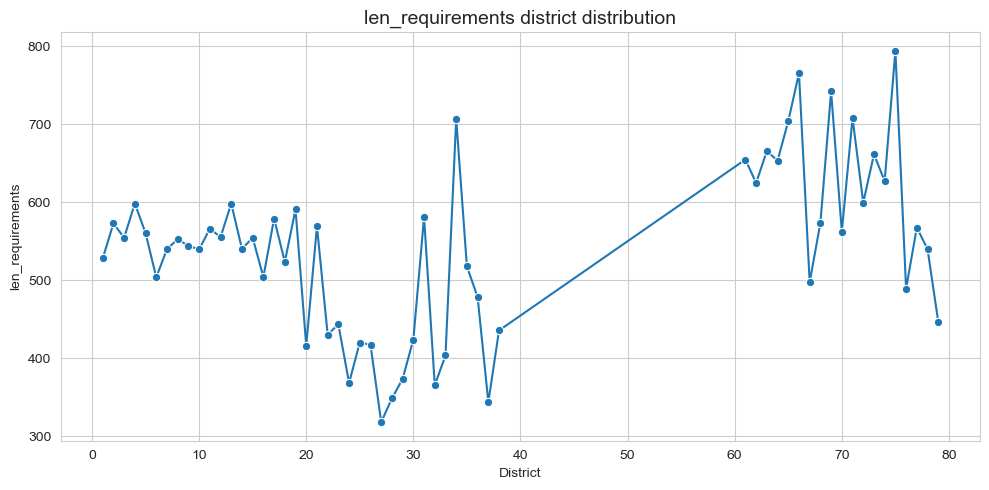

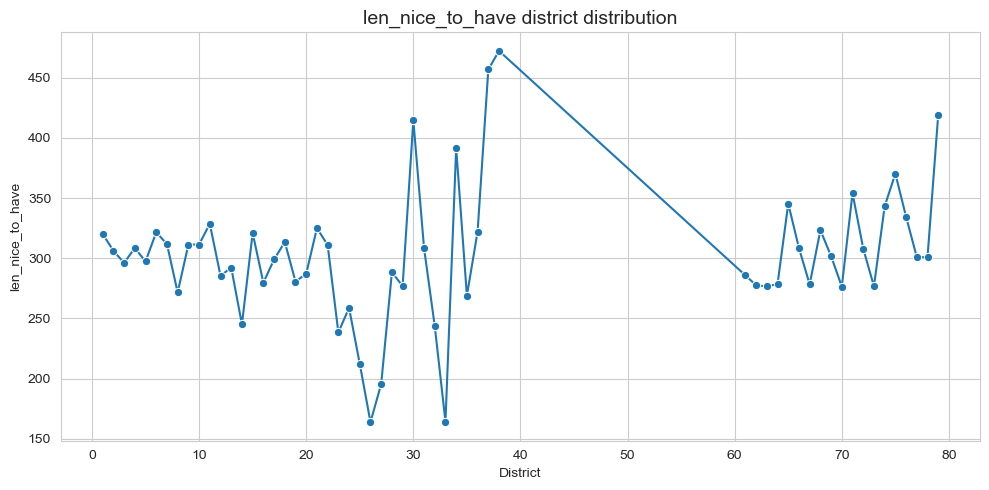

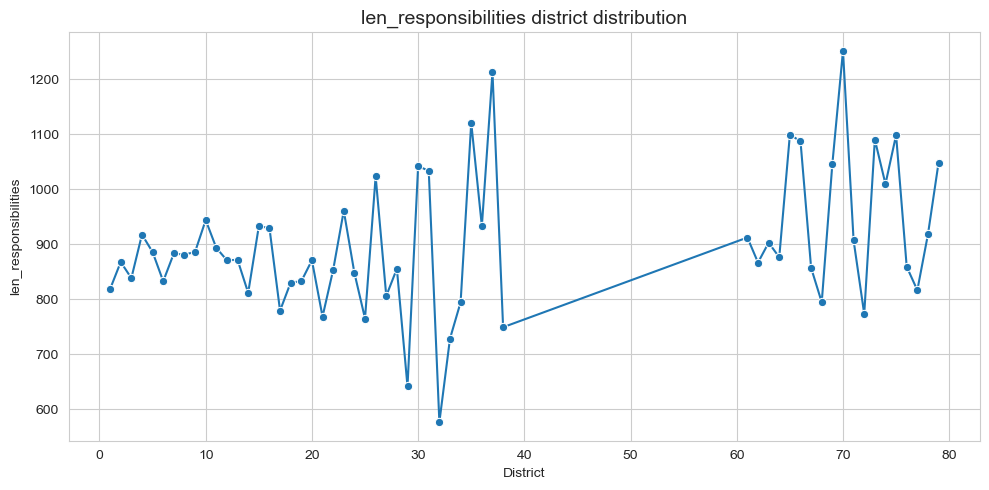

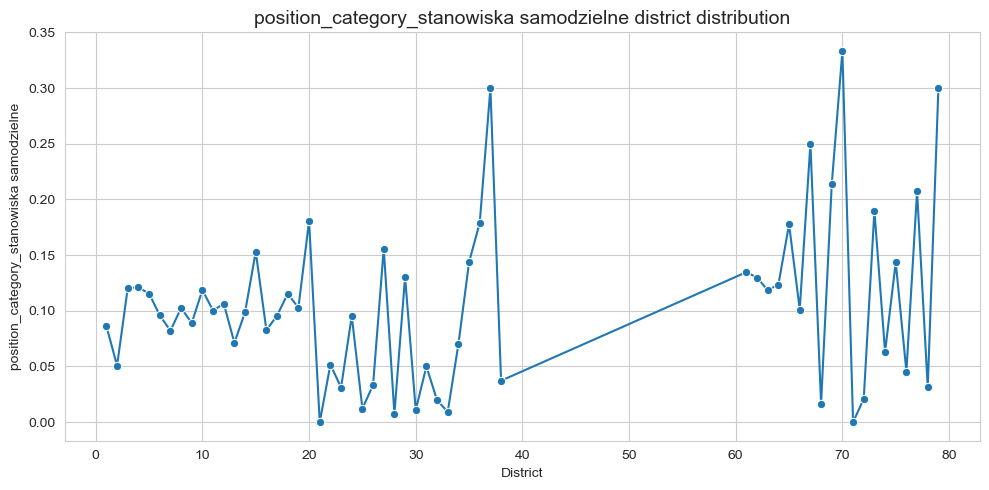

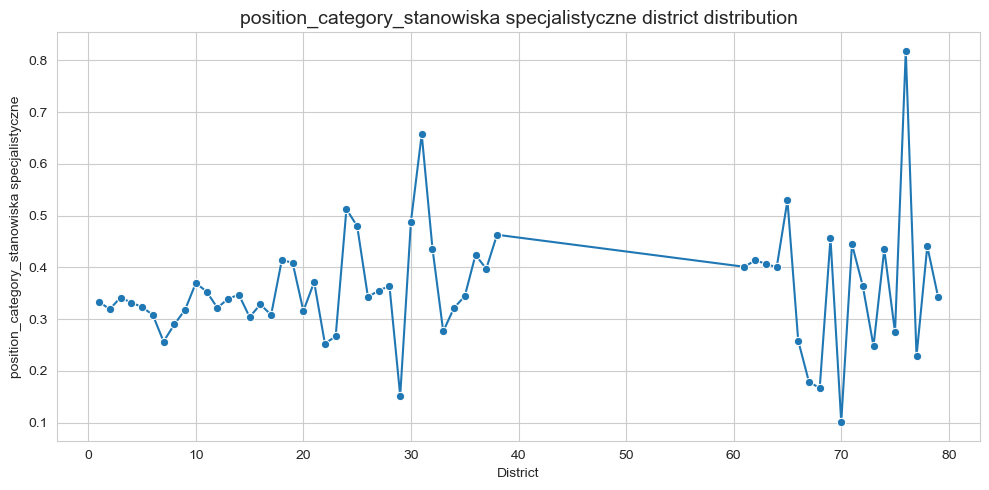

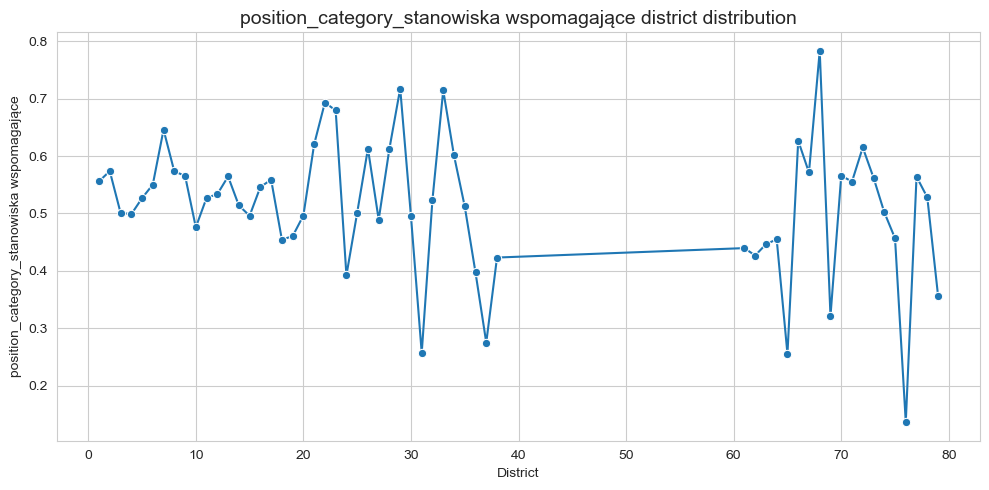

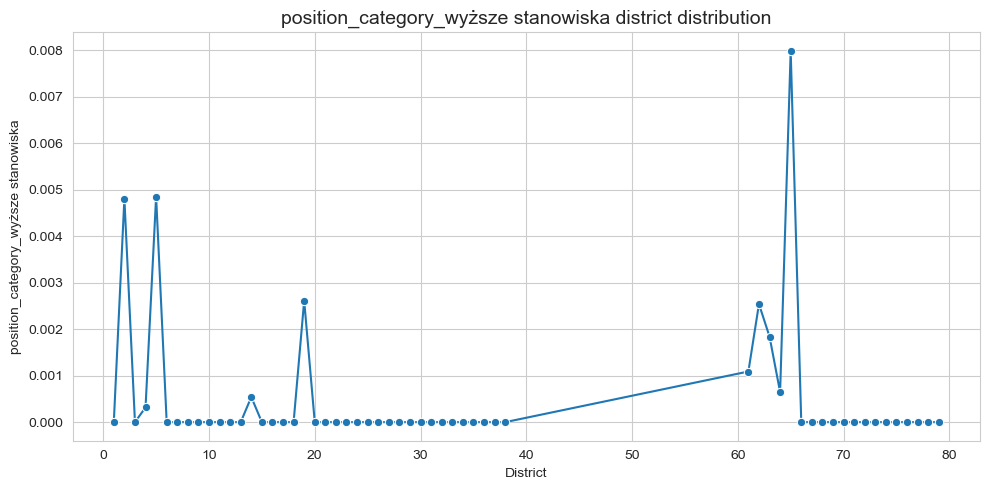

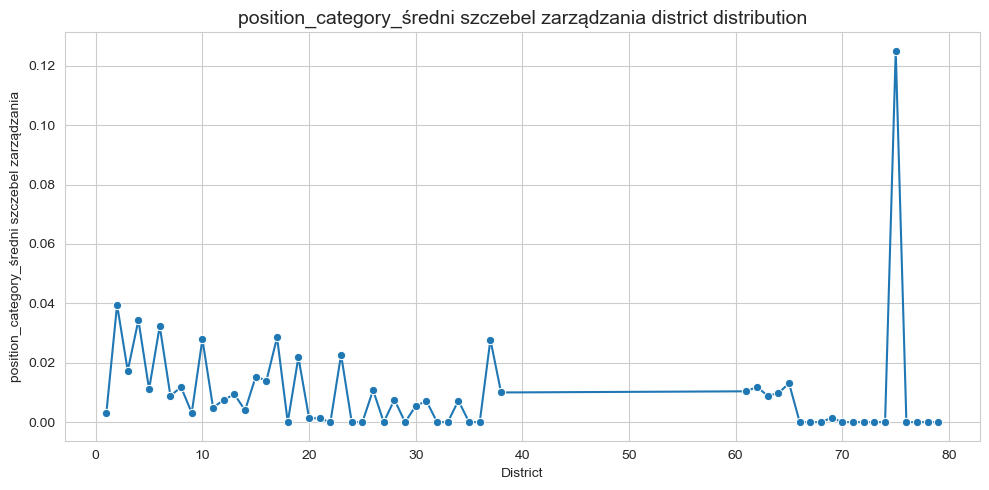

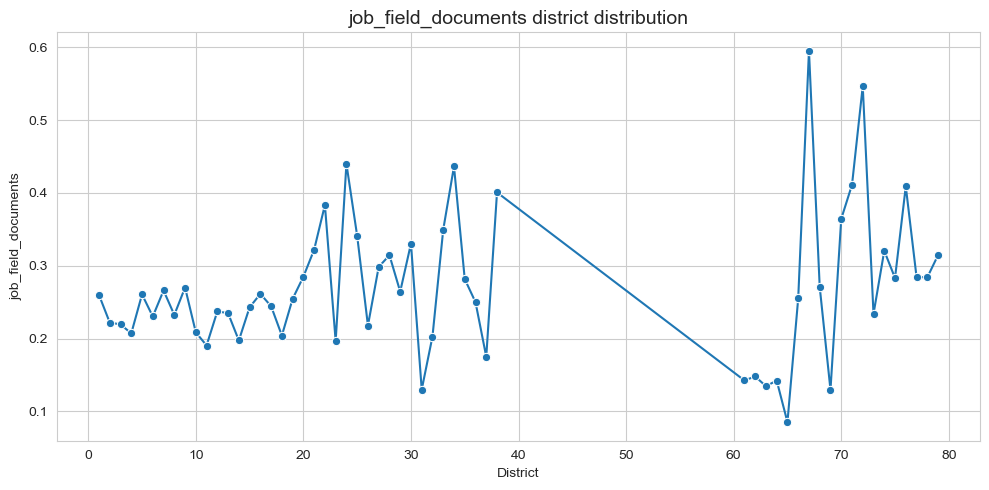

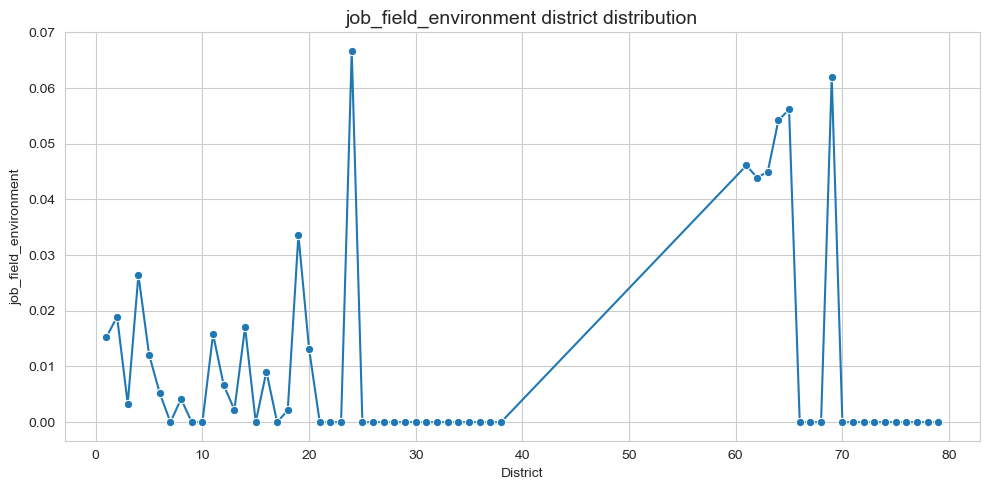

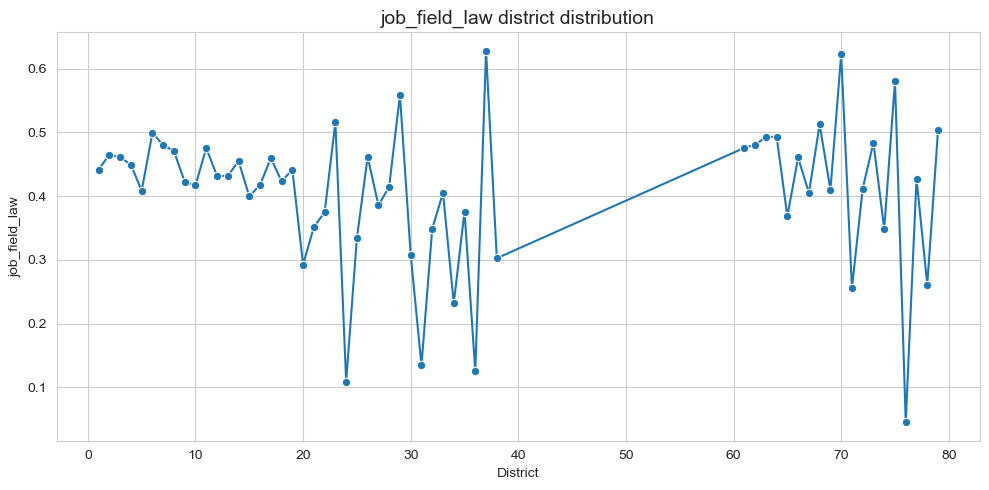

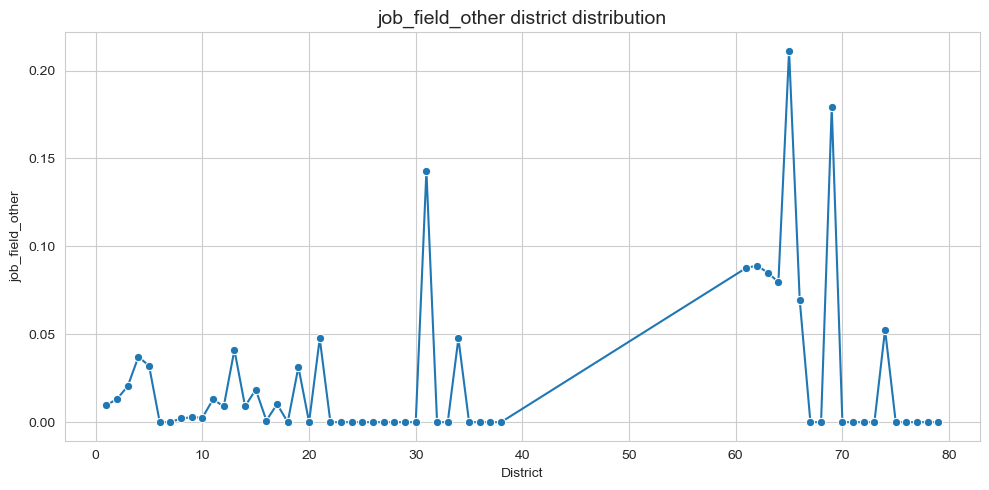

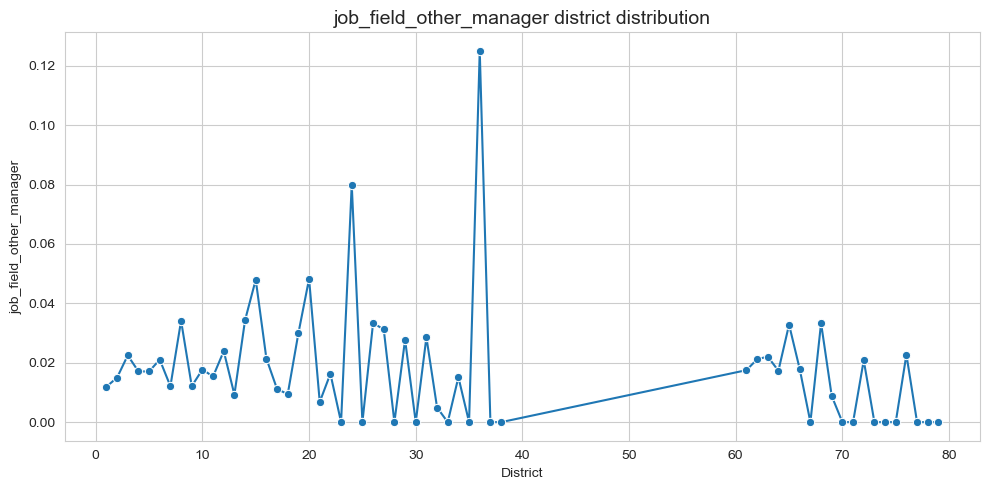

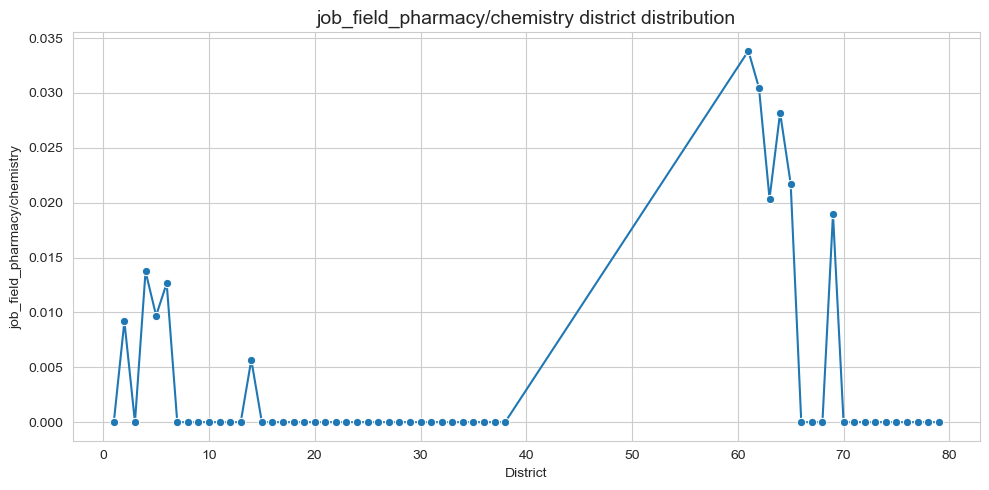

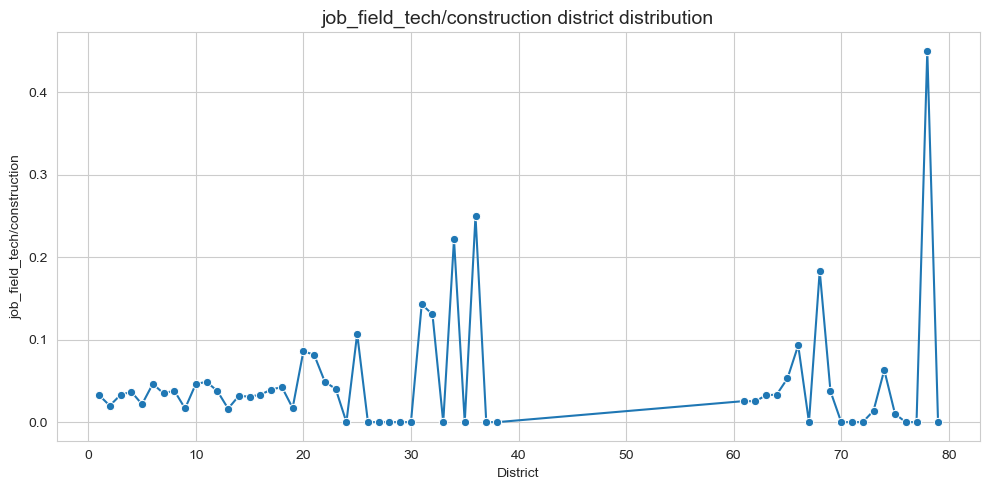

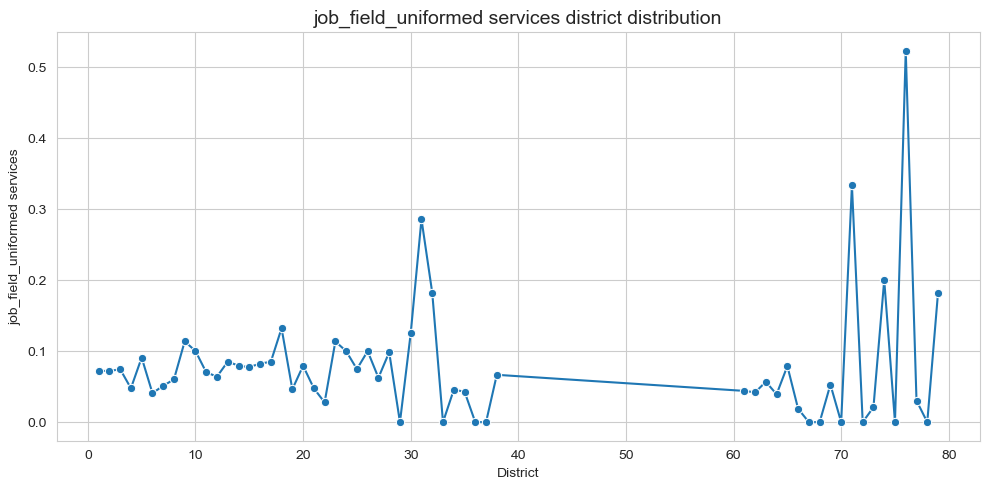

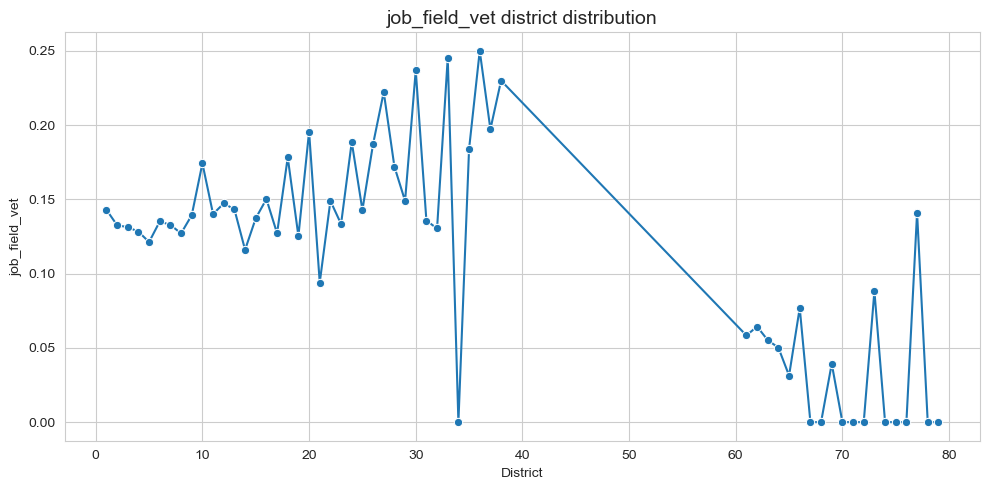

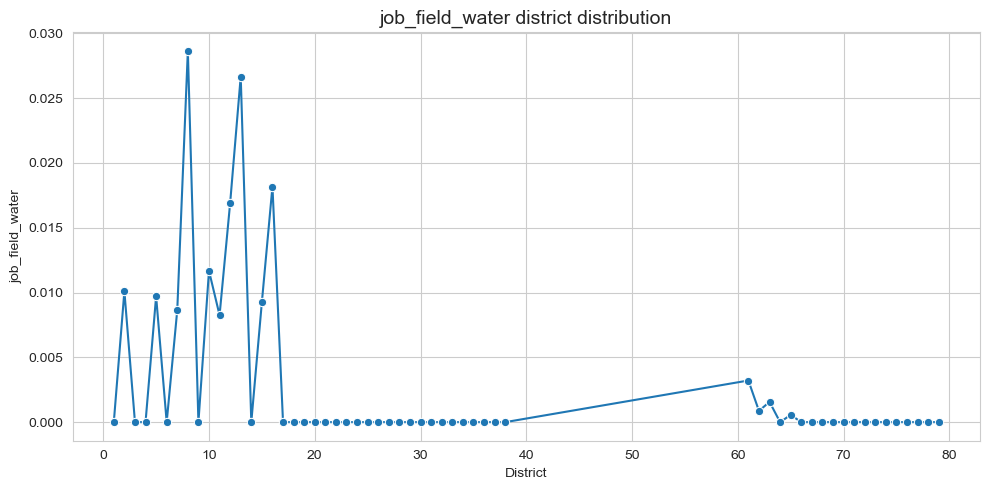

In [31]:
def plot_variability(dataframe):
    # Columns to exclude from plotting
    exclude_columns = ['work_time', 'year', 'district', 'voivodeship', 'institution']

    # Group by year and compute mean for numeric columns only.
    df_grouped = dataframe.groupby(['district']).mean(numeric_only=True)

    # Drop the excluded columns (if they exist).
    columns_to_plot = [col for col in df_grouped.columns if col not in exclude_columns]

    # Plot each column individually
    for column in columns_to_plot:
        plt.figure(figsize=(10, 5))
        sns.lineplot(x=df_grouped.index, y=df_grouped[column], marker='o')
        plt.title(f"{column} district variability", fontsize=14)
        plt.xlabel("District")
        plt.ylabel(column)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

plot_variability(df_institution_level)

## Feature importance

### Lasso

In [32]:
from sklearn.linear_model import Lasso, LassoCV
from sklearn.preprocessing import StandardScaler

In [33]:
df_for_lasso = df_institution_level.drop(columns=['institution', 'district', 'voivodeship', 'year'], axis=1)
df_for_lasso = df_for_lasso.dropna()
X = df_for_lasso.drop('result', axis=1)
y = df_for_lasso['result']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

lasso = LassoCV(cv=10, random_state=0).fit(X_scaled, y)

importance = pd.Series(lasso.coef_, index=X.columns)
importance = importance.sort_values(key=abs, ascending=False)
print(importance)

job_field_vet                                   -0.099893
applicants                                       0.064116
ad_views                                         0.024878
job_field_uniformed services                     0.024605
position_category_stanowiska specjalistyczne    -0.018495
job_field_documents                              0.017703
job_field_pharmacy/chemistry                    -0.017622
employment_contract                              0.015443
offer_salary_mentioned                           0.014178
bdl_district_expenses                            0.011194
vacancies                                        0.008869
fluctuation                                     -0.008103
bdl_average_salary                              -0.007790
len_nice_to_have                                -0.006796
position_category_średni szczebel zarządzania    0.006617
job_field_other_manager                          0.004662
len_requirements                                -0.004170
job_field_othe

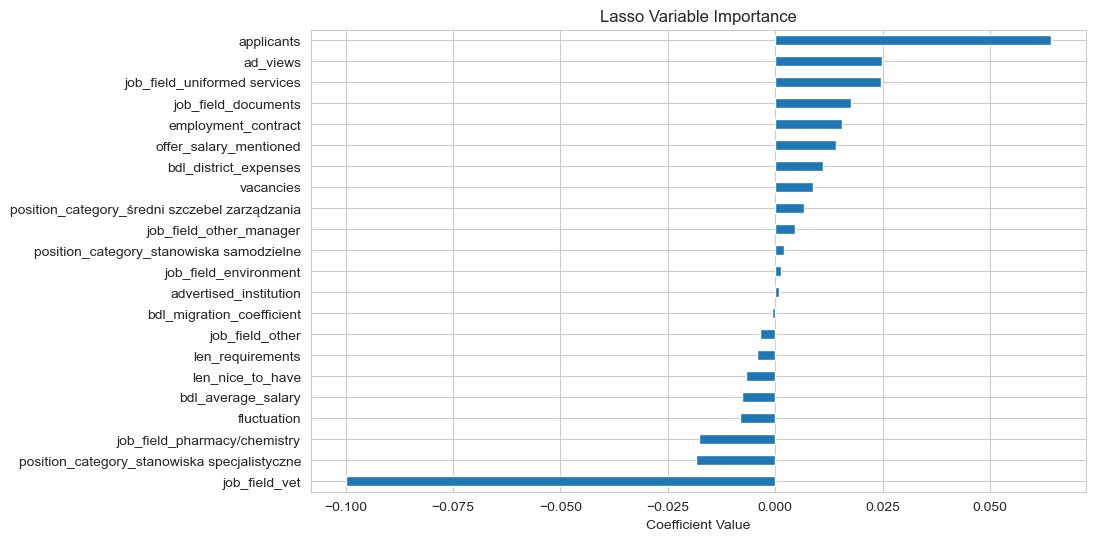

In [34]:
selected_features = importance[importance != 0].index.tolist()
df_institution_level = df_institution_level[selected_features]

importance[importance != 0].sort_values().plot(kind='barh', figsize=(10, 6))
plt.title('Lasso Variable Importance')
plt.xlabel('Coefficient Value')
plt.show()

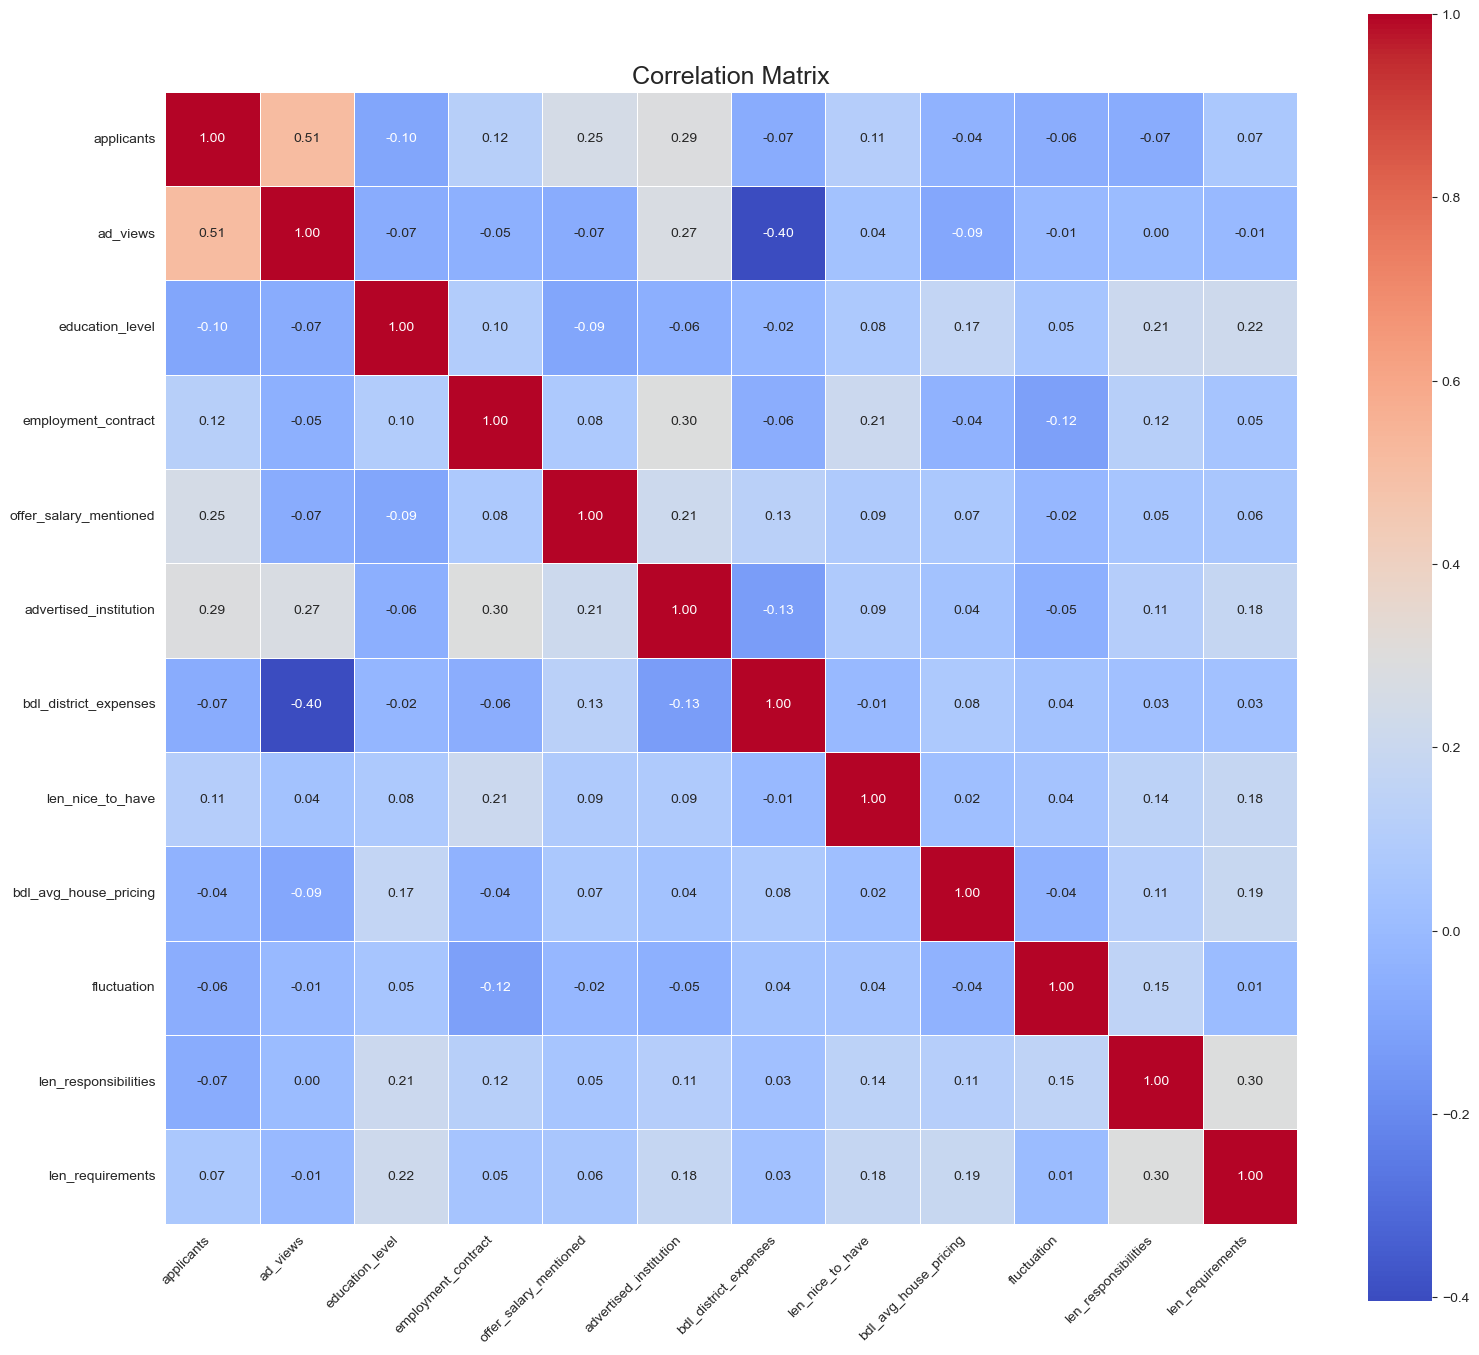

In [15]:
# Correlation matrix.
# df_corr_matrix = df_institution_level#.drop(columns=['institution', 'district', 'voivodeship', 'year'], axis=1)
# corr_matrix = df_corr_matrix.corr()
# 
# plt.figure(figsize=(16, 14))
# 
# sns.heatmap(
#     corr_matrix,
#     cmap="coolwarm",
#     annot=True,
#     fmt=".2f",
#     square=True,
#     linewidths=0.5,
#     cbar=True
# )
# 
# plt.title("Correlation Matrix", fontsize=18)
# plt.xticks(rotation=45, ha='right', fontsize=10)
# plt.yticks(rotation=0, fontsize=10)
# plt.tight_layout()
# plt.show()

##### Conclusions

In [ ]:
# As a result of the above analyses, I decided to exclude certain columns due to their low variability or low correlation.

cols_to_exclude = [
    'women_percentage',
    'bdl_feminization_coefficient',
    'work_time',
    'job_field_documents',
    'job_field_environment',
    'bdl_age_median',
    'job_field_water',
    'bdl_avg_house_pricing',
    'vacancies',
    'fluctuation',
    'salary_for_position'
]

df_institution_level = df_institution_level.drop(columns=cols_to_exclude, axis=1)